<a href="https://colab.research.google.com/github/QuakFooLee/python/blob/main/2024_07_Stock_News_and_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code Setup

In [ ]:
pip install -q numpy pandas matplotlib ta tensorflow scikit-learn keras yfinance mplfinance pandas_ta

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
pip install -q requests beautifulsoup4 textblob wordcloud yfinance googlesearch-python openpyxl

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.trend import MACD

from ta.trend import ADXIndicator

import yfinance as yf
import pandas as pd

In [ ]:
# Load your data (ensure you have a DataFrame named 'data_stock' with 'Close', 'Date', 'High', 'Low' columns)
# Example:
# data_stock = pd.read_csv('sample_data/TSLA.csv') # Ensure the CSV file is loaded correctly
# filtered_data_stock = data_stock[(data_stock['Date'] >= '2024-01-01') & (data_stock['Date'] <= '2024-07-05')]

# Fetch the data from Yahoo Finance
ticker = 'MSFT'
start_date = '2024-01-01'
end_date = '2024-07-05'
data_stock = yf.download(ticker, start=start_date, end=end_date)

# Reset the index to move the 'Date' from index to column
data_stock.reset_index(inplace=True)

# Display the data to verify the 'Date' column
data_stock.head()

# Filter the data (if needed, but yfinance already provides the data within the specified range)
filtered_data_stock = data_stock[(data_stock['Date'] >= start_date) & (data_stock['Date'] <= end_date)]

# Display the filtered data
filtered_data_stock.tail()

[*********************100%%**********************]  1 of 1 completed


Date        Open        High         Low       Close   Adj Close  \
122 2024-06-27  452.179993  456.170013  451.769989  452.850006  452.850006   
123 2024-06-28  453.070007  455.380005  446.410004  446.950012  446.950012   
124 2024-07-01  448.660004  457.369995  445.660004  456.730011  456.730011   
125 2024-07-02  453.200012  459.589996  453.109985  459.279999  459.279999   
126 2024-07-03  458.190002  461.019989  457.880005  460.769989  460.769989   

       Volume  
122  14806300  
123  28362300  
124  17662800  
125  13979800  
126   9932800

# Stocks Screening

https://chatgpt.com/c/d64a761f-7b2a-4d9a-b853-5f4238a14bf8

In [ ]:
import yfinance as yf
import pandas as pd

# Function to fetch financial data and filter based on criteria
def screen_stocks(tickers):
    screened_stocks = []

    for ticker in tickers:
        stock = yf.Ticker(ticker)
        info = stock.info

        # Fetch P/E ratio and revenue
        pe_ratio = info.get('trailingPE', None)
        revenue = info.get('totalRevenue', None)

        # Convert revenue to billions if it's not None
        if revenue is not None:
            revenue = revenue / 1e9

        # Check if the stock meets the criteria
        if pe_ratio is not None and revenue is not None:
            if 10 <= pe_ratio <= 50 and revenue > 1:
                screened_stocks.append({
                    'Ticker': ticker,
                    'Company': info.get('longName', ticker),
                    'P/E Ratio': pe_ratio,
                    'Revenue (Billion)': revenue
                })

    return pd.DataFrame(screened_stocks)

# Define the tickers of interest (replace with a comprehensive list of tickers)
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'FB', 'TSLA', 'BRK-B', 'V', 'JPM', 'JNJ',
    'WMT', 'PG', 'NVDA', 'DIS', 'MA', 'HD', 'UNH', 'PYPL', 'VZ', 'ADBE'
]

# Screen the stocks based on the criteria
screened_stocks_df = screen_stocks(tickers)

# Display the screened stocks
print(screened_stocks_df)

# Optionally, save the screened stocks to an Excel file
screened_stocks_df.to_excel('screened_stocks.xlsx', index=False)


   Ticker                          Company  P/E Ratio  Revenue (Billion)
0    AAPL                       Apple Inc.  35.485980         381.623009
1    MSFT            Microsoft Corporation  40.332176         236.583993
2   GOOGL                    Alphabet Inc.  28.992330         318.145987
3   BRK-B          Berkshire Hathaway Inc.  12.063698         368.958013
4       V                        Visa Inc.  29.765364          34.141000
5     JPM             JPMorgan Chase & Co.  12.374548         150.000992
6     JNJ                Johnson & Johnson  21.584570          85.647999
7     WMT                     Walmart Inc.  29.905580         657.331978
8      PG     The Procter & Gamble Company  27.164764          84.059996
9      MA          Mastercard Incorporated  35.472176          25.698001
10     HD             The Home Depot, Inc.  22.776660         151.830004
11    UNH  UnitedHealth Group Incorporated  29.856010         379.486994
12   PYPL            PayPal Holdings, Inc.  14.8841

In [ ]:
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup

# Function to get S&P 500 companies
def get_sp500_symbols():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', {'id': 'constituents'})
    symbols = []
    for row in table.findAll('tr')[1:]:
        symbol = row.findAll('td')[0].text.strip()
        symbols.append(symbol)
    return symbols

# Get S&P 500 symbols
stock_symbols = get_sp500_symbols()

# Initialize an empty list to store results
screened_stocks = []

# Function to get stock data and apply filters
def screen_stock(symbol):
    stock = yf.Ticker(symbol)
    info = stock.info

    try:
        pe_ratio = info.get('forwardPE', None)
        market_cap = info.get('marketCap', None)

        if pe_ratio and market_cap:
            if 10 <= pe_ratio <= 50 and market_cap > 100e9:
                screened_stocks.append({
                    'Symbol': symbol,
                    'P/E Ratio': pe_ratio,
                    'Market Cap': market_cap
                })
    except KeyError:
        pass

# Screen each stock
for symbol in stock_symbols:
    screen_stock(symbol)

# Convert the results to a DataFrame for easy viewing
screened_stocks_df = pd.DataFrame(screened_stocks)

# Display the screened stocks
print(screened_stocks_df)


   Symbol  P/E Ratio    Market Cap
0     ABT  19.867704  177651007488
1    ABBV  13.807629  294052659200
2     ACN  23.414387  187583217664
3    ADBE  27.959185  255132368896
4     AMD  31.966011  288818429952
..    ...        ...           ...
82   VRTX  26.697510  124353159168
83      V  23.828264  545081032704
84    WMT  26.000000  560473899008
85    DIS  17.671507  177509416960
86    WFC  10.594254  205727744000

[87 rows x 3 columns]


In [ ]:
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup

# Function to get S&P 500 companies
def get_sp500_symbols():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', {'id': 'constituents'})
    symbols = []
    for row in table.findAll('tr')[1:]:
        symbol = row.findAll('td')[0].text.strip()
        symbols.append(symbol)
    return symbols

# Function to get Dow Jones Industrial Average companies
def get_djia_symbols():
    url = "https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', {'class': 'wikitable sortable'})
    symbols = []
    for row in table.findAll('tr')[1:]:
        symbol = row.findAll('td')[2].text.strip()
        symbols.append(symbol)
    return symbols

# Function to get Nasdaq-100 companies
def get_nasdaq100_symbols():
    url = "https://en.wikipedia.org/wiki/Nasdaq-100"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', {'class': 'wikitable sortable'})
    symbols = []
    for row in table.findAll('tr')[1:]:
        symbol = row.findAll('td')[1].text.strip()
        symbols.append(symbol)
    return symbols

# Get S&P 500, DJIA, and Nasdaq-100 symbols
sp500_symbols = get_sp500_symbols()
djia_symbols = get_djia_symbols()
nasdaq100_symbols = get_nasdaq100_symbols()
stock_symbols = list(set(sp500_symbols + djia_symbols + nasdaq100_symbols))  # Combine and remove duplicates

# Initialize an empty list to store results
screened_stocks = []

# Function to get stock data and apply filters
def screen_stock(symbol):
    stock = yf.Ticker(symbol)
    info = stock.info

    try:
        pe_ratio = info.get('forwardPE', None)
        market_cap = info.get('marketCap', None)

        if pe_ratio and market_cap:
            if 10 <= pe_ratio <= 50 and market_cap > 1000e9:
                screened_stocks.append({
                    'Symbol': symbol,
                    'P/E Ratio': pe_ratio,
                    'Market Cap': market_cap
                })
    except KeyError:
        pass

# Screen each stock
for symbol in stock_symbols:
    screen_stock(symbol)

# Convert the results to a DataFrame for easy viewing
screened_stocks_df = pd.DataFrame(screened_stocks)

# Save the screened stocks to an Excel file
excel_file = 'screened_stocks.xlsx'
screened_stocks_df.to_excel(excel_file, index=False)

# Display the location of the saved file
print(f'Screened stocks saved to {excel_file}')


ERROR:yfinance:404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MANAGED%20HEALTH%20CARE?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MANAGED+HEALTH+CARE&crumb=c%2FIFmUwSecj
ERROR:yfinance:404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AEROSPACE%20AND%20DEFENSE?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=AEROSPACE+AND+DEFENSE&crumb=c%2FIFmUwSecj
ERROR:yfinance:404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FOOD%20INDUSTRY?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FOOD+INDUSTRY&crumb=c%2FIFmUwSecj
ERROR:yfinance:404 Client Error: Not Found for url: https://query2.f

Screened stocks saved to screened_stocks.xlsx


In [ ]:
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup

# Function to get S&P 500 companies
def get_sp500_symbols():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', {'id': 'constituents'})
    symbols = []
    for row in table.findAll('tr')[1:]:
        symbol = row.findAll('td')[0].text.strip()
        symbols.append(symbol)
    return symbols

# Function to get Dow Jones Industrial Average companies
def get_djia_symbols():
    url = "https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', {'class': 'wikitable sortable'})
    symbols = []
    for row in table.findAll('tr')[1:]:
        symbol = row.findAll('td')[2].text.strip()
        symbols.append(symbol)
    return symbols

# Function to get Nasdaq-100 companies
def get_nasdaq100_symbols():
    url = "https://en.wikipedia.org/wiki/Nasdaq-100"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', {'class': 'wikitable sortable'})
    symbols = []
    for row in table.findAll('tr')[1:]:
        symbol = row.findAll('td')[1].text.strip()
        symbols.append(symbol)
    return symbols

# Get S&P 500, DJIA, and Nasdaq-100 symbols
sp500_symbols = get_sp500_symbols()
djia_symbols = get_djia_symbols()
nasdaq100_symbols = get_nasdaq100_symbols()
stock_symbols = list(set(sp500_symbols + djia_symbols + nasdaq100_symbols))  # Combine and remove duplicates

# Initialize an empty list to store results
screened_stocks = []

# Function to get stock data and apply filters
def screen_stock(symbol):
    stock = yf.Ticker(symbol)
    info = stock.info

    try:
        pe_ratio = info.get('forwardPE', None)
        eps = info.get('trailingEps', None)
        market_cap = info.get('marketCap', None)

        if pe_ratio and eps and market_cap:
            if 5 <= pe_ratio <= 50 and eps > 5 and market_cap > 100e9:
                screened_stocks.append({
                    'Symbol': symbol,
                    'P/E Ratio': pe_ratio,
                    'EPS': eps,
                    'Market Cap': market_cap
                })
    except KeyError:
        pass

# Screen each stock
for symbol in stock_symbols:
    screen_stock(symbol)

# Convert the results to a DataFrame for easy viewing
screened_stocks_df = pd.DataFrame(screened_stocks)

# Save the screened stocks to an Excel file
excel_file = 'screened_stocks.xlsx'
screened_stocks_df.to_excel(excel_file, index=False)

# Display the location of the saved file
print(f'Screened stocks saved to {excel_file}')


ERROR:yfinance:404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MANAGED%20HEALTH%20CARE?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MANAGED+HEALTH+CARE&crumb=c%2FIFmUwSecj
ERROR:yfinance:404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AEROSPACE%20AND%20DEFENSE?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=AEROSPACE+AND+DEFENSE&crumb=c%2FIFmUwSecj
ERROR:yfinance:404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FOOD%20INDUSTRY?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FOOD+INDUSTRY&crumb=c%2FIFmUwSecj
ERROR:yfinance:404 Client Error: Not Found for url: https://query2.f

Screened stocks saved to screened_stocks.xlsx


# Financial Analysis

In [ ]:
import yfinance as yf
import pandas as pd # Import pandas to use pd.ExcelWriter

def fetch_financial_reports(ticker):
    # Create a Ticker object
    stock = yf.Ticker(ticker)

    # Extract financial reports
    financials = stock.financials
    quarterly_financials = stock.quarterly_financials
    balance_sheet = stock.balance_sheet
    quarterly_balance_sheet = stock.quarterly_balance_sheet
    cashflow = stock.cashflow
    quarterly_cashflow = stock.quarterly_cashflow

    return {
        'Financials': financials,
        'Quarterly Financials': quarterly_financials,
        'Balance Sheet': balance_sheet,
        'Quarterly Balance Sheet': quarterly_balance_sheet,
        'Cashflow': cashflow,
        'Quarterly Cashflow': quarterly_cashflow
    }

# Example usage
ticker = "AMZN"
reports = fetch_financial_reports(ticker)

# Display the reports
for report_name, report_data in reports.items():
    print(f"\n{report_name}:\n")
    print(report_data)

# Optionally, save the reports to Excel files
with pd.ExcelWriter(f'{ticker}_financial_reports.xlsx') as writer: # Now pd is recognized
    for report_name, report_data in reports.items():
        report_data.to_excel(writer, sheet_name=report_name[:31])


Financials:

                                                          2023-12-31  \
Tax Effect Of Unusual Items                         211380035.679101   
Tax Rate For Calcs                                          0.189579   
Normalized EBITDA                                      88287000000.0   
Total Unusual Items                                     1115000000.0   
Total Unusual Items Excluding Goodwill                  1115000000.0   
Net Income From Continuing Operation Net Minori...     30425000000.0   
Reconciled Depreciation                                48663000000.0   
Reconciled Cost Of Revenue                            480980000000.0   
EBITDA                                                 89402000000.0   
EBIT                                                   40739000000.0   
Net Interest Income                                     -233000000.0   
Interest Expense                                        3182000000.0   
Interest Income                                   

In [ ]:
import yfinance as yf
import pandas as pd

def fetch_financial_data(ticker):
    stock = yf.Ticker(ticker)
    financials = stock.financials
    balance_sheet = stock.balance_sheet
    cashflow = stock.cashflow
    return financials, balance_sheet, cashflow

def calculate_ratios(financials, balance_sheet, cashflow):
    # Example ratios
    ratios = {}
    try:
        total_revenue = financials.loc['Total Revenue'].iloc[0]
        net_income = financials.loc['Net Income'].iloc[0]
        total_assets = balance_sheet.loc['Total Assets'].iloc[0]
        total_liabilities = balance_sheet.loc['Total Liabilities Net Minority Interest'].iloc[0]
        total_equity = total_assets - total_liabilities
        ebit = financials.loc['EBIT'].iloc[0]
        interest_expense = financials.loc['Interest Expense'].iloc[0]

        ratios['Return on Assets (ROA)'] = net_income / total_assets
        ratios['Return on Equity (ROE)'] = net_income / total_equity
        ratios['Debt to Equity Ratio'] = total_liabilities / total_equity
        ratios['Interest Coverage Ratio'] = ebit / interest_expense
    except Exception as e:
        print(f"Error in calculating ratios: {e}")
    return ratios

# Example usage
ticker = "MSFT"
financials, balance_sheet, cashflow = fetch_financial_data(ticker)
ratios = calculate_ratios(financials, balance_sheet, cashflow)

# Example industry benchmarks (these values are hypothetical)
industry_benchmarks = {
    'Return on Assets (ROA)': 0.08,
    'Return on Equity (ROE)': 0.15,
    'Debt to Equity Ratio': 0.5,
    'Interest Coverage Ratio': 10
}

# Compare with industry benchmarks
comparison = pd.DataFrame({
    'Ratio': list(ratios.keys()),
    'Company': list(ratios.values()),
    'Industry Benchmark': [industry_benchmarks[ratio] for ratio in ratios.keys()]
})

comparison['Comparison'] = comparison['Company'] / comparison['Industry Benchmark']

print(comparison)



                     Ratio    Company  Industry Benchmark  Comparison
0   Return on Assets (ROA)   0.175644                0.08    2.195547
1   Return on Equity (ROE)   0.350887                0.15    2.339248
2     Debt to Equity Ratio   0.997721                0.50    1.995442
3  Interest Coverage Ratio  46.381606               10.00    4.638161


Financials:
            Tax Effect Of Unusual Items Tax Rate For Calcs Normalized EBITDA  \
2023-06-30                  -2850000.0               0.19    105155000000.0   
2022-06-30                  43420000.0               0.13     99905000000.0   
2021-06-30            180160797.164637           0.138266     83831000000.0   
2020-06-30                   4760000.0               0.17     68395000000.0   

           Total Unusual Items Total Unusual Items Excluding Goodwill  \
2023-06-30         -15000000.0                            -15000000.0   
2022-06-30         334000000.0                            334000000.0   
2021-06-30        1303000000.0                           1303000000.0   
2020-06-30          28000000.0                             28000000.0   

           Net Income From Continuing Operation Net Minority Interest  \
2023-06-30                                      72361000000.0           
2022-06-30                                      72738000000.0           
2021-0

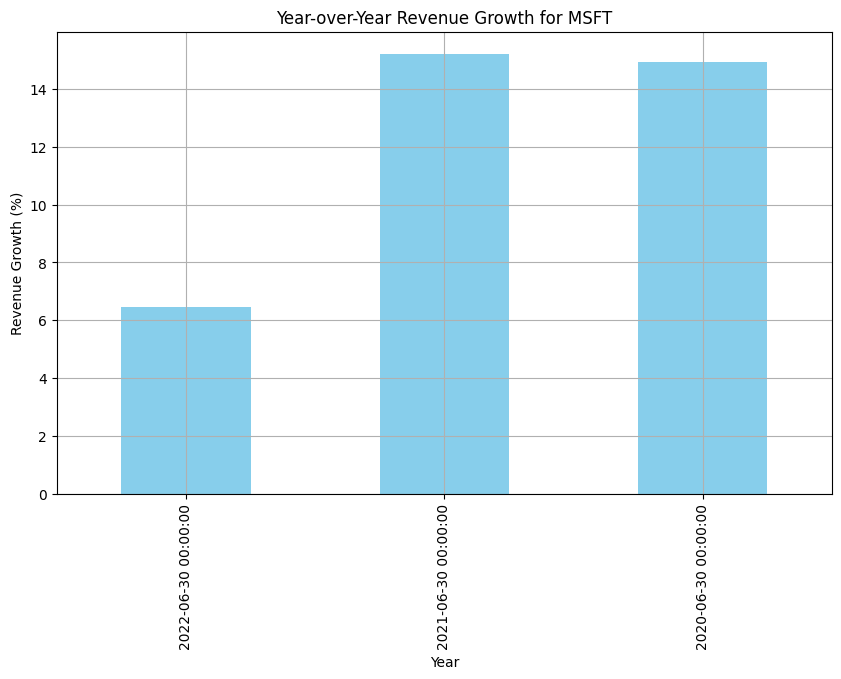

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

def fetch_financial_reports(ticker):
    # Create a Ticker object
    stock = yf.Ticker(ticker)

    # Extract financial reports
    financials = stock.financials.T  # Transpose to get years as index
    return financials

def calculate_revenue_growth(financials):
    # Calculate year-over-year revenue growth
    revenue = financials['Total Revenue']
    revenue_growth = -revenue.pct_change().dropna() * 100  # Drop NA values and convert to percentage
    return revenue_growth

def plot_revenue_growth(revenue_growth, ticker):
    # Plot revenue growth
    plt.figure(figsize=(10, 6))
    revenue_growth.plot(kind='bar', color='skyblue')
    plt.title(f'Year-over-Year Revenue Growth for {ticker}')
    plt.xlabel('Year')
    plt.ylabel('Revenue Growth (%)')
    plt.grid(True)
    plt.show()

# Example usage
# ticker = "AMZN"
financials = fetch_financial_reports(ticker)

# Display the financials for verification
print("Financials:\n", financials)

# Calculate and display revenue growth
revenue_growth = calculate_revenue_growth(financials)
print(f"\nYear-over-Year Revenue Growth for {ticker}:\n", revenue_growth)

# Plot the revenue growth
plot_revenue_growth(revenue_growth, ticker)


Quarterly Financials:
            Tax Effect Of Unusual Items Tax Rate For Calcs Normalized EBITDA  \
2024-03-31                 -33660000.0               0.18     33741000000.0   
2023-12-31                 -29160000.0               0.18     33556000000.0   
2023-09-30                 -20700000.0               0.18     31845000000.0   
2023-06-30             20855987.382214           0.187892     28972000000.0   
2023-03-31                  30780000.0               0.19     26556000000.0   
2022-12-31                         NaN                NaN               NaN   

           Total Unusual Items Total Unusual Items Excluding Goodwill  \
2024-03-31        -187000000.0                           -187000000.0   
2023-12-31        -162000000.0                           -162000000.0   
2023-09-30        -115000000.0                           -115000000.0   
2023-06-30         111000000.0                            111000000.0   
2023-03-31         162000000.0                            

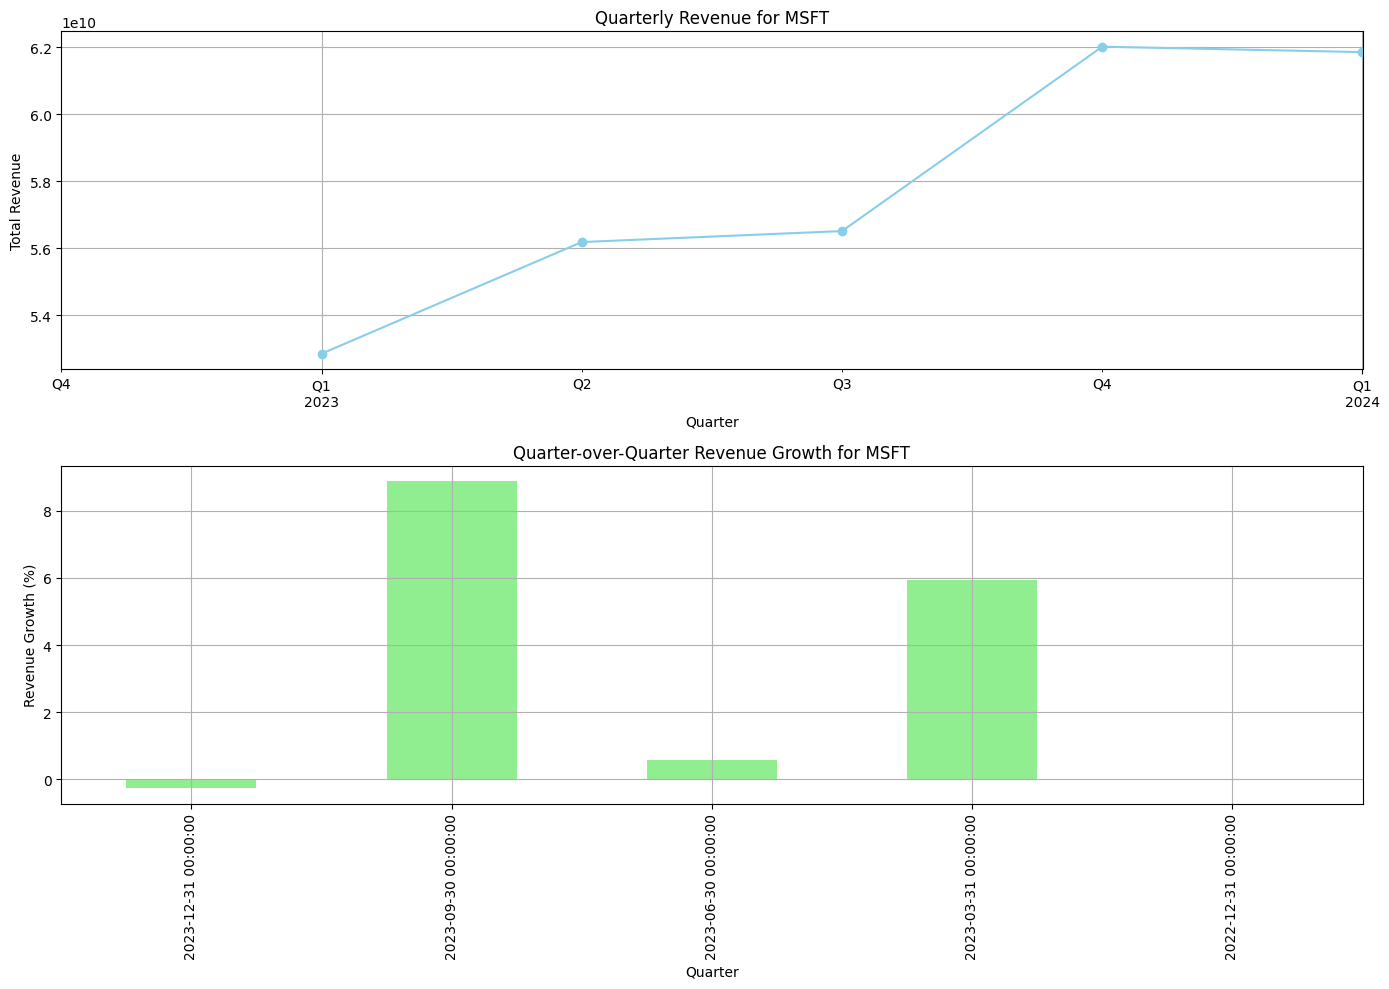

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

def fetch_quarterly_financial_reports(ticker):
    # Create a Ticker object
    stock = yf.Ticker(ticker)

    # Extract quarterly financial reports
    quarterly_financials = stock.quarterly_financials.T  # Transpose to get quarters as index
    return quarterly_financials

def calculate_quarterly_revenue_growth(quarterly_financials):
    # Calculate quarter-over-quarter revenue growth
    revenue = quarterly_financials['Total Revenue']
    quarterly_revenue_growth = -revenue.pct_change().dropna() * 100  # Drop NA values and convert to percentage
    return quarterly_revenue_growth

def plot_quarterly_revenue_trends(quarterly_financials, quarterly_revenue_growth, ticker):
    # Plot quarterly revenue and revenue growth
    plt.figure(figsize=(14, 10))

    # Plot the quarterly revenue
    plt.subplot(2, 1, 1)
    quarterly_financials['Total Revenue'].plot(kind='line', marker='o', color='skyblue')
    plt.title(f'Quarterly Revenue for {ticker}')
    plt.xlabel('Quarter')
    plt.ylabel('Total Revenue')
    plt.grid(True)

    # Plot the quarterly revenue growth
    plt.subplot(2, 1, 2)
    quarterly_revenue_growth.plot(kind='bar', color='lightgreen')
    plt.title(f'Quarter-over-Quarter Revenue Growth for {ticker}')
    plt.xlabel('Quarter')
    plt.ylabel('Revenue Growth (%)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
# ticker = "MSFT"
quarterly_financials = fetch_quarterly_financial_reports(ticker)

# Display the financials for verification
print("Quarterly Financials:\n", quarterly_financials)

# Calculate and display quarterly revenue growth
quarterly_revenue_growth = calculate_quarterly_revenue_growth(quarterly_financials)
print(f"\nQuarter-over-Quarter Revenue Growth for {ticker}:\n", quarterly_revenue_growth)

# Plot the quarterly revenue trends
plot_quarterly_revenue_trends(quarterly_financials, quarterly_revenue_growth, ticker)


In [ ]:
import yfinance as yf
import pandas as pd

# Define the list of tickers for the companies
tickers = ['TSLA', 'MSFT', 'AAPL', 'META', 'GOOGL', 'AMZN', 'AMD', 'SU', 'NFLX', 'ORCL', 'NVDA', 'MARA', 'RIOT', 'SBUX', 'DELL', 'CNQ', 'ENB', 'INTC', 'PLTR','ARM', 'AMAT', 'MU','CLSK']


# Initialize a DataFrame to store the ratios
# ratios_df = pd.DataFrame(columns=['Stock Symbol', 'Company', 'Sector', 'P/E Ratio', 'PEG Ratio', 'EPS', 'Enterprise Value/Revenue', 'Enterprise Value/EBITDA', 'Profit Margin'])
ratios_df = pd.DataFrame()

# Fetch financial metrics for each company
for ticker in tickers:
    stock = yf.Ticker(ticker)
    info = stock.info

    # Extracting the required information
    symbol = ticker  # Stock symbol
    company = info.get('longName', ticker)  # Company name
    sector = info.get('sector', 'N/A')  # Industrial sector
    market_cap = info.get('marketCap', 'N/A')  # Market cap
    enterprise_value = info.get('enterpriseValue', 'N/A')  # Enterprise value
    pe_ratio = info.get('trailingPE', 'N/A')  # Trailing P/E ratio
    peg_ratio = info.get('pegRatio', 'N/A')  # PEG ratio
    eps = info.get('trailingEps', 'N/A')  # Trailing EPS
    ev_to_revenue = info.get('enterpriseToRevenue', 'N/A')  # Enterprise Value/Revenue
    ev_to_ebitda = info.get('enterpriseToEbitda', 'N/A')  # Enterprise Value/EBITDA
    profit_margin = info.get('profitMargins', 'N/A')  # Profit margin
    operating_margin = info.get('operatingMargins', 'N/A')  # Operating margin
    roa = info.get('returnOnAssets', 'N/A')  # Return on assets
    roe = info.get('returnOnEquity', 'N/A')  # Return on equity

    # Convert market cap and enterprise value to billions if they are not 'N/A'
    if market_cap != 'N/A':
        market_cap /= 1e9
    if enterprise_value != 'N/A':
        enterprise_value /= 1e9

    # Convert margins and returns to percentages if they are not 'N/A'
    if profit_margin != 'N/A':
        profit_margin *= 100
    if operating_margin != 'N/A':
        operating_margin *= 100
    if roa != 'N/A':
        roa *= 100
    if roe != 'N/A':
        roe *= 100

    new_row = pd.Series({'Stock Symbol': symbol,
        'Company': company,
        'Sector': sector,
        'Market Cap (Billion)': market_cap,
        'Enterprise Value (Billion)': enterprise_value,
        'P/E Ratio': pe_ratio,
        'PEG Ratio': peg_ratio,
        'EPS': eps,
        'Enterprise Value/Revenue': ev_to_revenue,
        'Enterprise Value/EBITDA': ev_to_ebitda,
        'Profit Margin (%)': profit_margin,
        'Operating Margin (%)': operating_margin,
        'Return on Assets (%)': roa,
        'Return on Equity (%)': roe})

    ratios_df = pd.concat([ratios_df, new_row.to_frame().T], ignore_index=True)

# Set the 'Company' column as the index
ratios_df.set_index('Company', inplace=True)

# Sort the DataFrame by the 'Sector' column in ascending order
ratios_df.sort_values(by='Sector', ascending=True, inplace=True)

# Export the DataFrame to an Excel file
ratios_df.to_excel('financial_ratios_comparison.xlsx', sheet_name='Financial Ratios')

print("The financial ratios have been exported to 'financial_ratios_comparison.xlsx'.")

# Display the DataFrame
ratios_df_display = ratios_df.style.set_caption('Financial Ratios Comparison').set_table_styles(
    [{'selector': 'caption', 'props': [('text-align', 'center'), ('font-size', '20px')]}]
)
ratios_df_display




The financial ratios have been exported to 'financial_ratios_comparison.xlsx'.


First few rows of the data:
                Company Stock Symbol                  Sector  \
0  Meta Platforms, Inc.         META  Communication Services   
1         Alphabet Inc.        GOOGL  Communication Services   
2         Netflix, Inc.         NFLX  Communication Services   
3           Tesla, Inc.         TSLA       Consumer Cyclical   
4      Amazon.com, Inc.         AMZN       Consumer Cyclical   

   Market Cap (Billion)  Enterprise Value (Billion)  P/E Ratio  PEG Ratio  \
0           1339.287798                 1349.013209  30.362278       0.84   
1           2345.534489                 2275.720823  29.016104       1.25   
2            294.529466                  307.111854  47.367985       1.40   
3            803.455107                  785.996644  64.597435       7.50   
4           2066.074305                 2156.811518  55.456707       1.44   

     EPS  Enterprise Value/Revenue  Enterprise Value/EBITDA  \
0  17.39                     9.453                   19.709  

<Figure size 1400x1000 with 0 Axes>

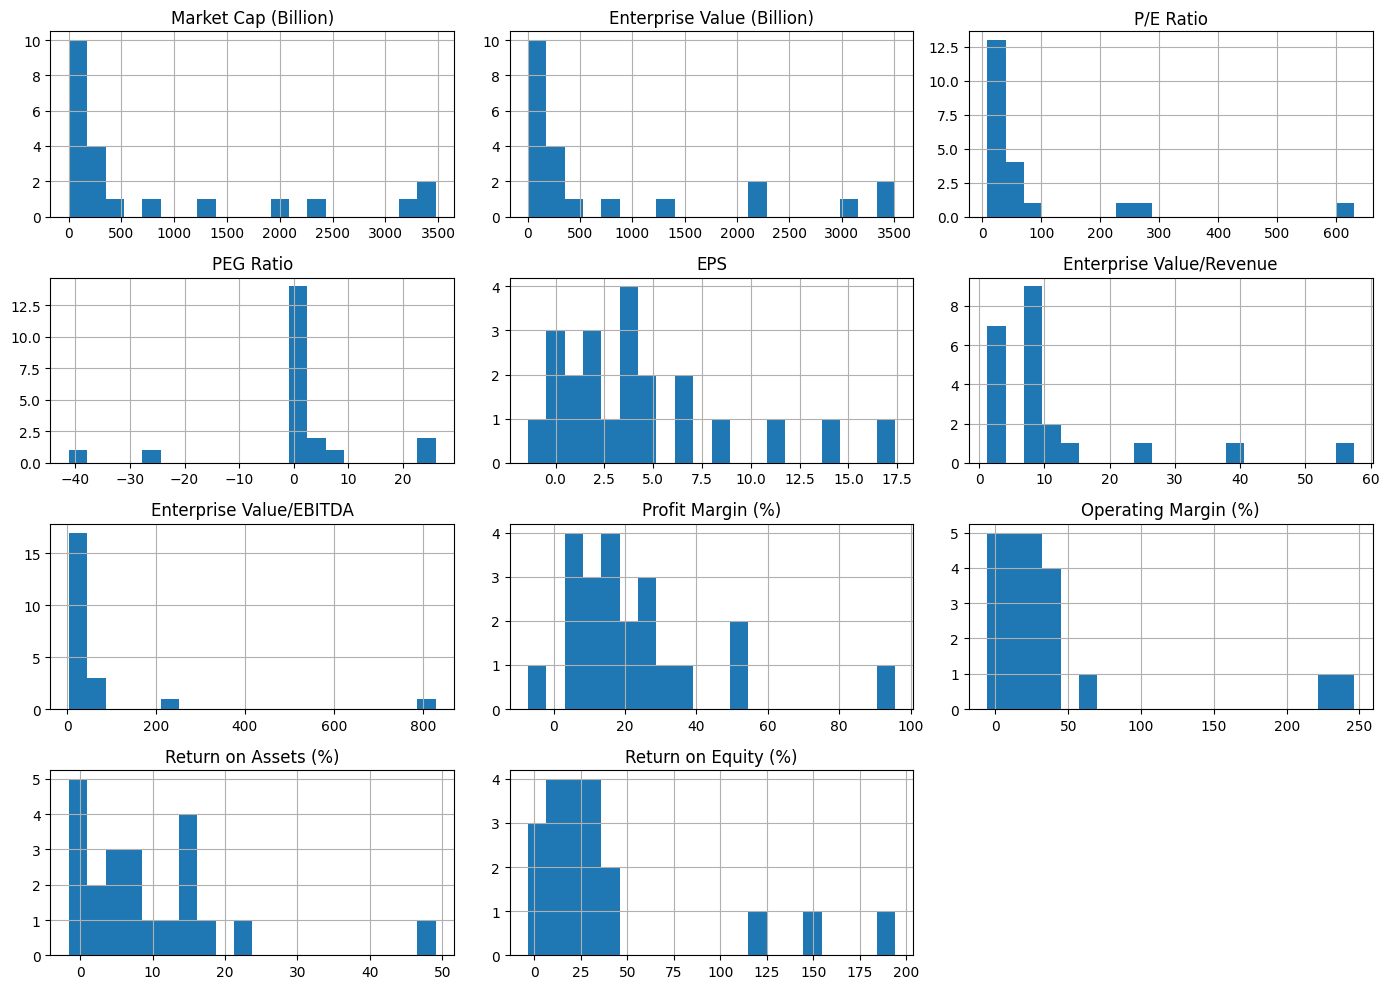

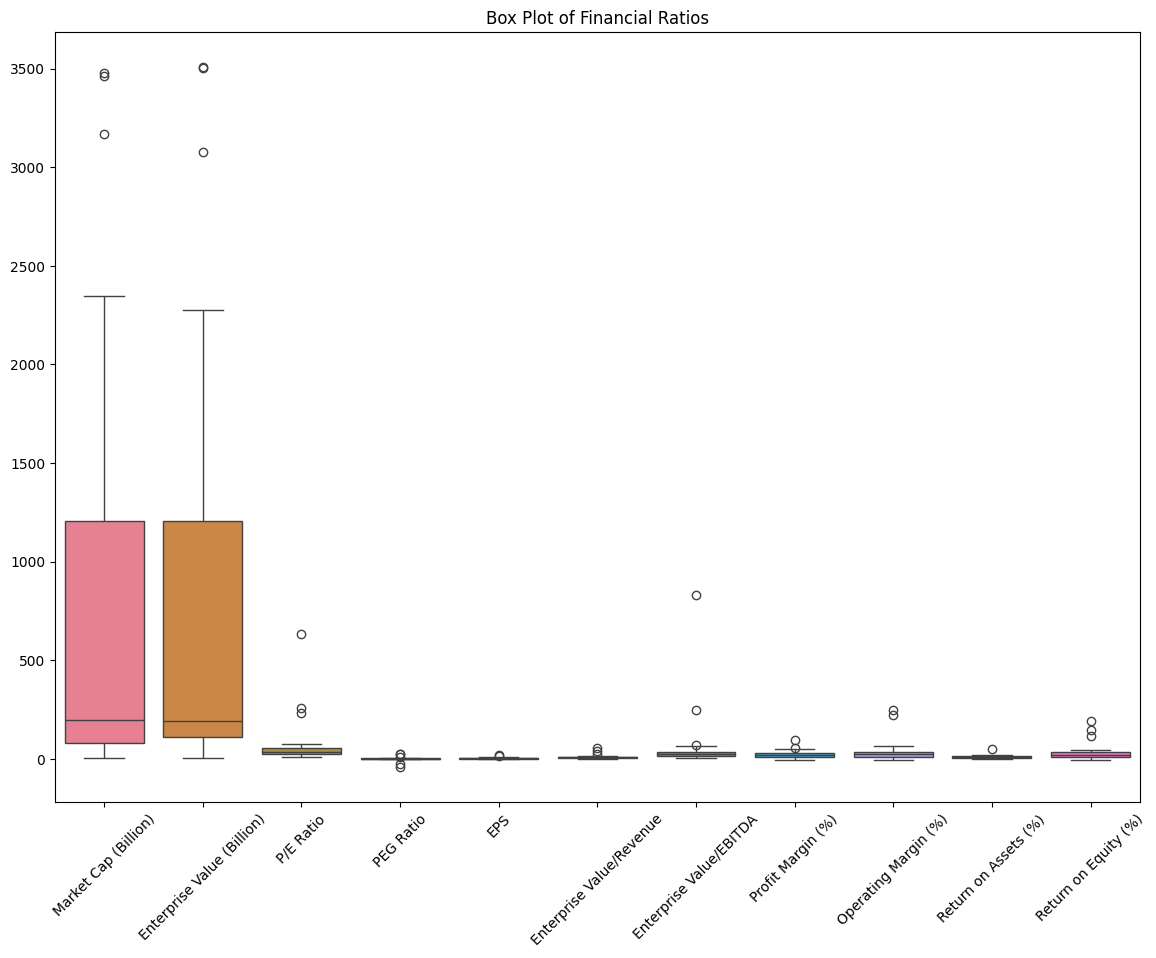

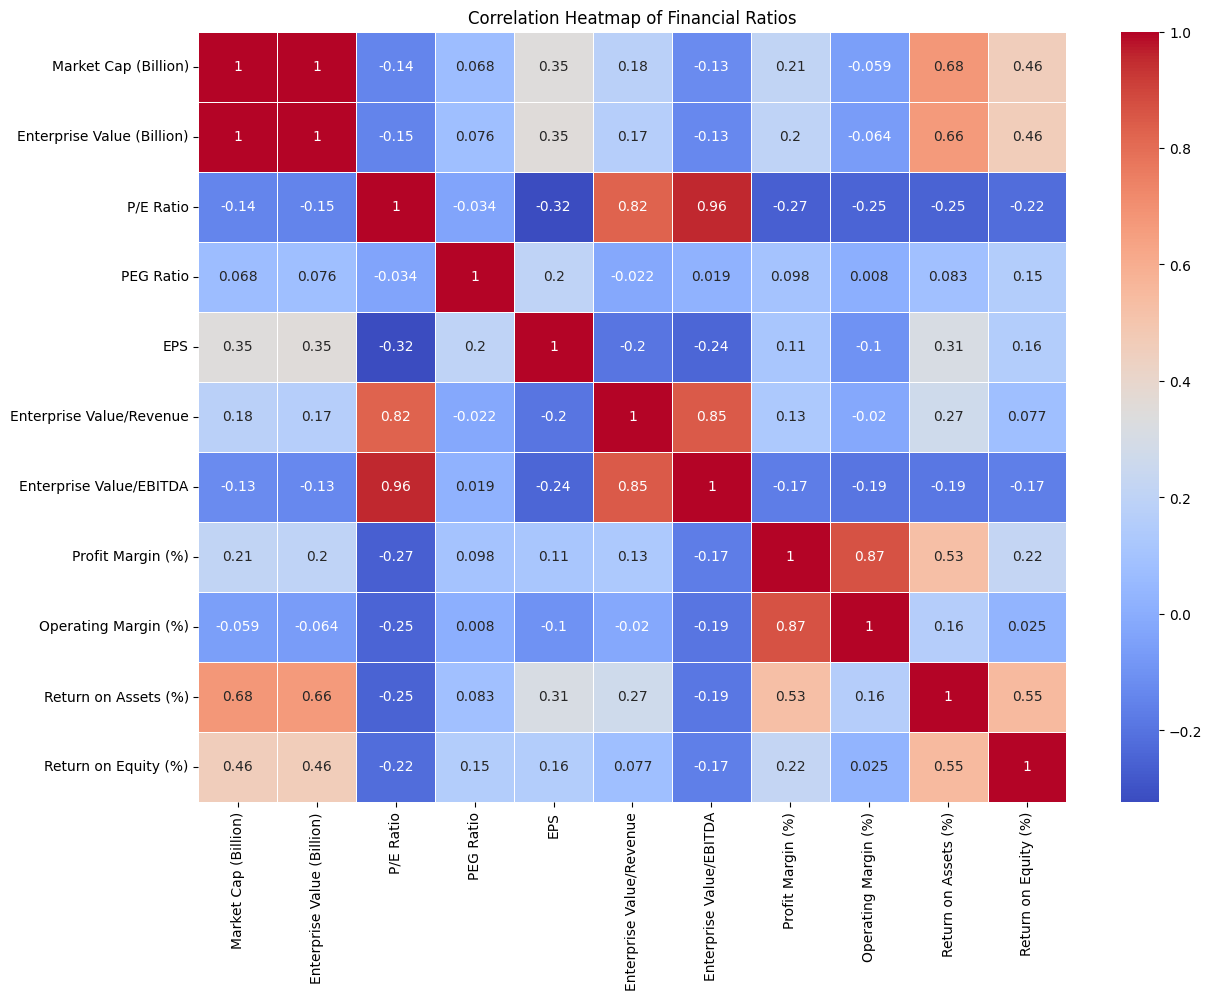

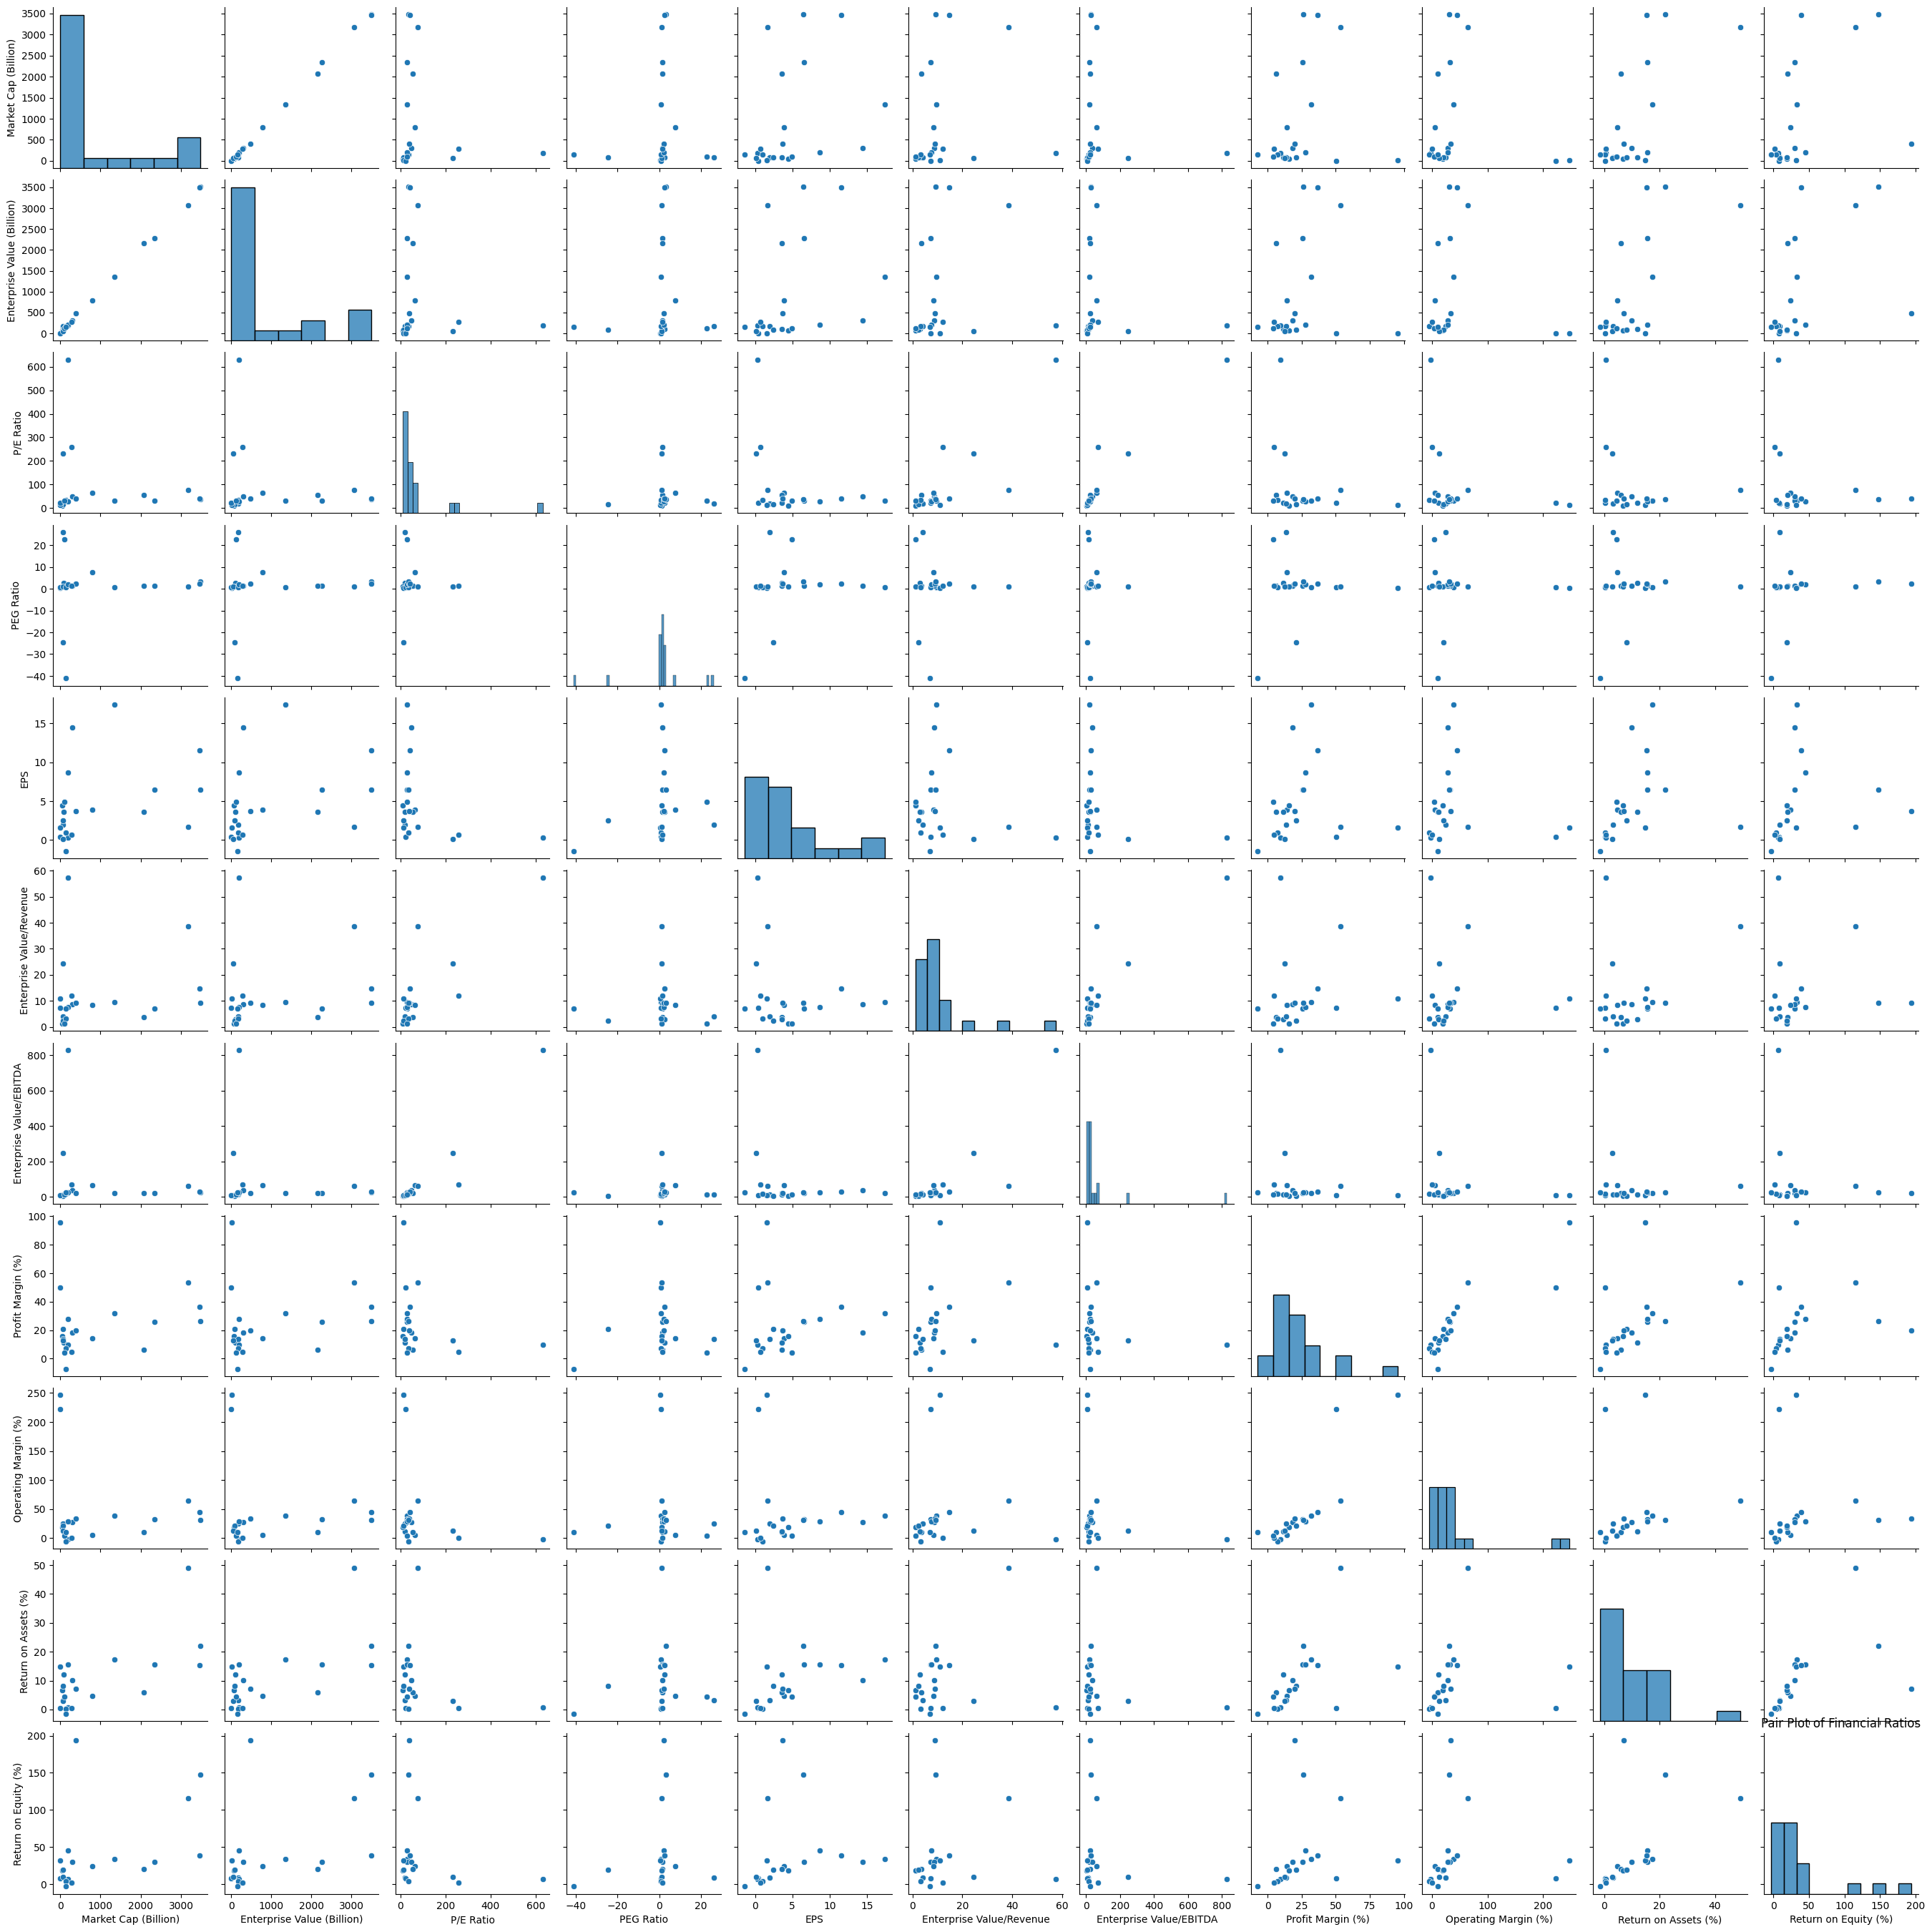

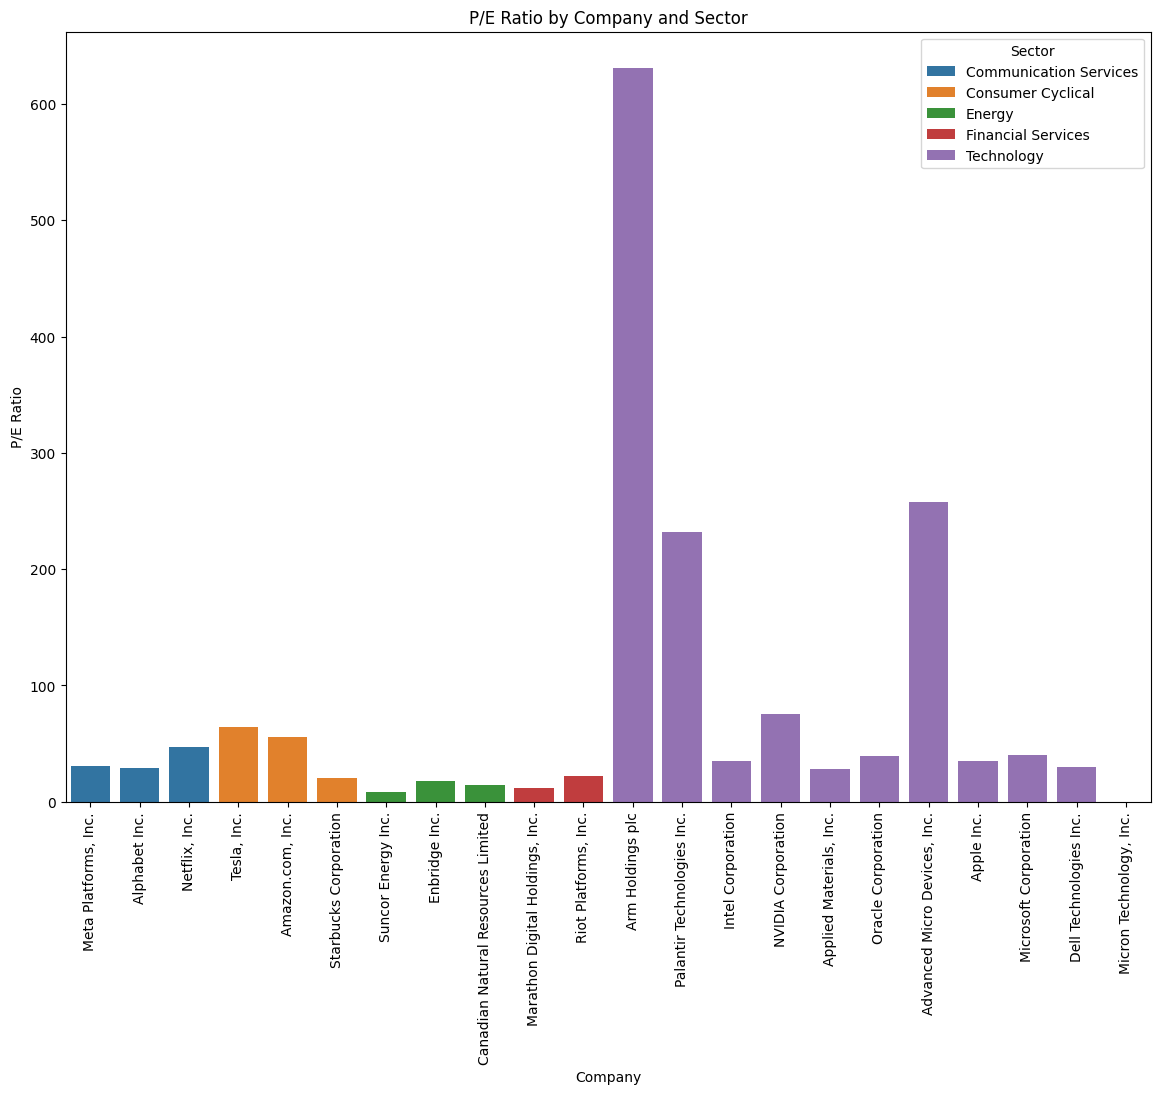

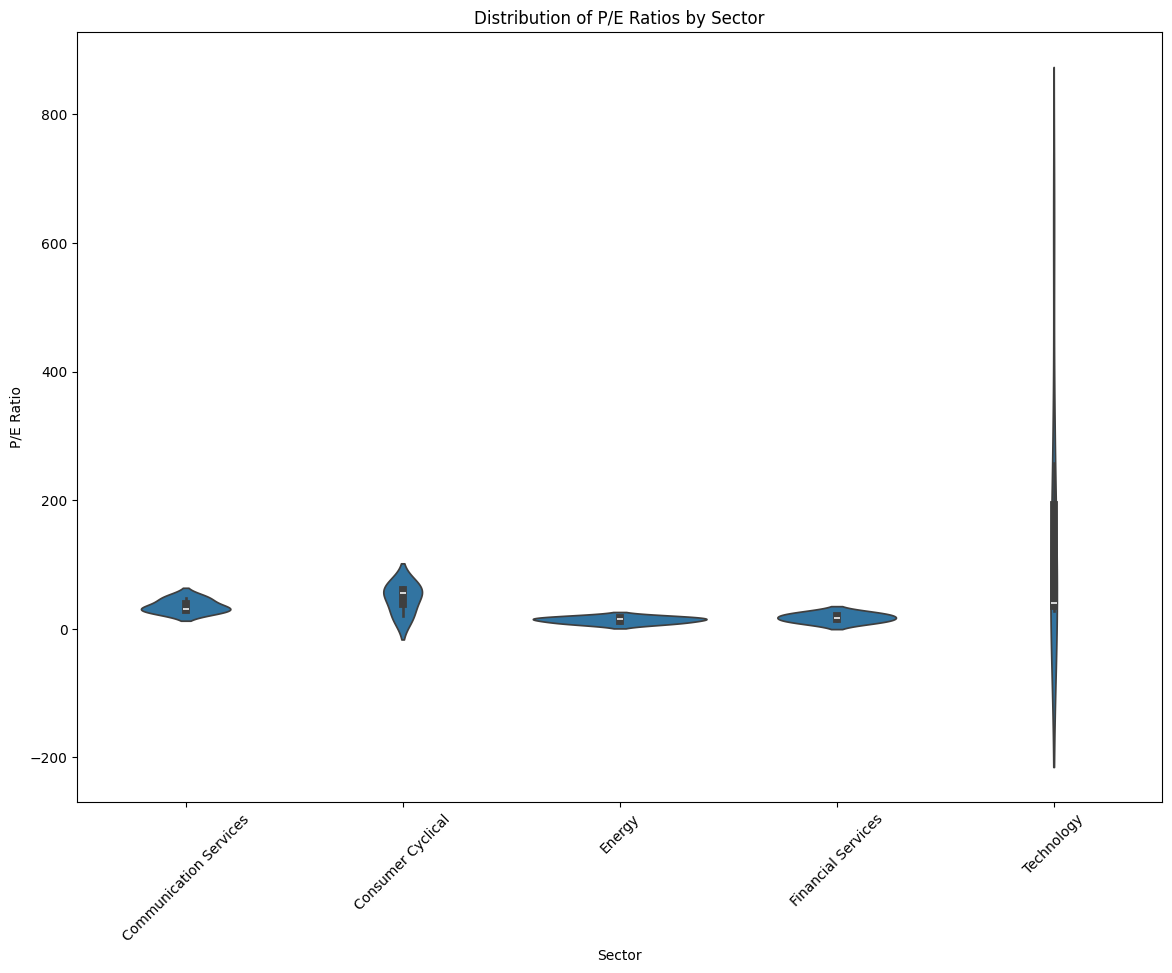

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the Excel file
ratios_df = pd.read_excel('financial_ratios_comparison.xlsx', index_col=0)

# Reset the index to make 'Company' a regular column
ratios_df = ratios_df.reset_index()  # This line is added to fix the error

# Display the first few rows of the DataFrame
print("First few rows of the data:")
print(ratios_df.head())

# Display basic statistical summaries
print("\nStatistical Summary:")
print(ratios_df.describe())

# Check for missing values
print("\nMissing Values:")
print(ratios_df.isnull().sum())

# Visualize the distribution of each ratio
plt.figure(figsize=(14, 10))
ratios_df.hist(bins=20, figsize=(14, 10))
plt.tight_layout()
plt.show()

# Box plots to visualize the spread and outliers in the data
plt.figure(figsize=(14, 10))
sns.boxplot(data=ratios_df)
plt.xticks(rotation=45)
plt.title("Box Plot of Financial Ratios")
plt.show()

# Correlation heatmap
plt.figure(figsize=(14, 10))
# Select only numeric columns for correlation calculation
corr = ratios_df.select_dtypes(include=['number']).corr()  # This line is modified to fix the error
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Financial Ratios")
plt.show()

# Pair plot to visualize relationships between variables
sns.pairplot(ratios_df.select_dtypes(include=['number']))  # This line is modified to fix the error
plt.title("Pair Plot of Financial Ratios")
plt.show()

# Bar plot to compare ratios by sector
plt.figure(figsize=(14, 10))
sns.barplot(x='Company', y='P/E Ratio', hue='Sector', data=ratios_df)
plt.xticks(rotation=90)
plt.title("P/E Ratio by Company and Sector")
plt.show()

# Violin plot to see the distribution of P/E ratios across sectors
plt.figure(figsize=(14, 10))
sns.violinplot(x='Sector', y='P/E Ratio', data=ratios_df)
plt.xticks(rotation=45)
plt.title("Distribution of P/E Ratios by Sector")
plt.show()

Available years in the data: DatetimeIndex(['2023-12-31', '2022-12-31', '2021-12-31', '2020-12-31',
               '2019-12-31'],
              dtype='datetime64[ns]', freq=None)


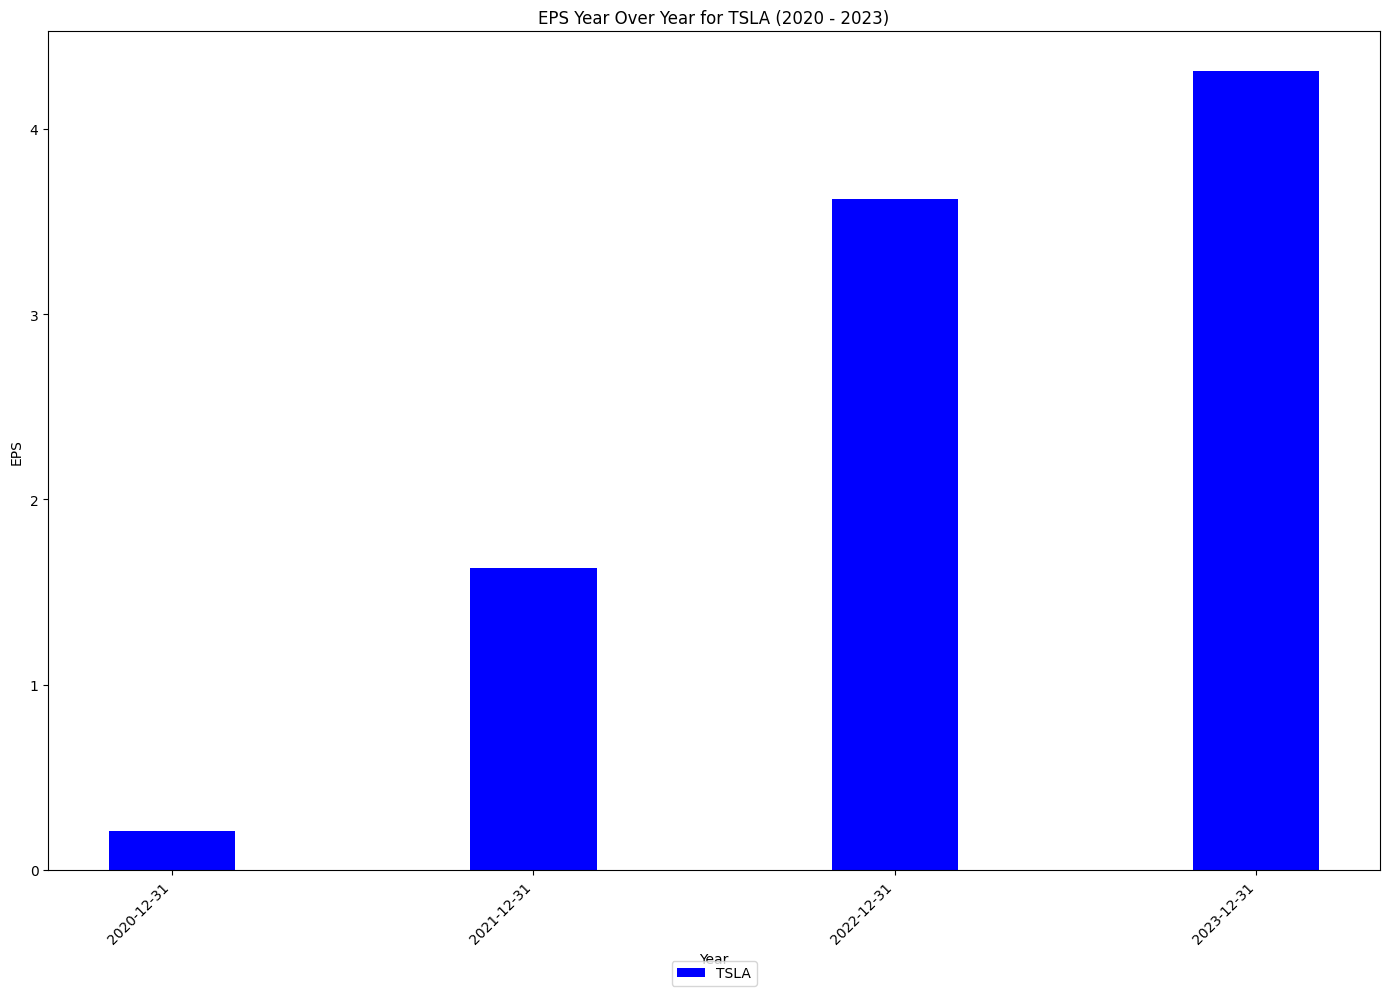

2020-12-31    0.213333
2021-12-31        1.63
2022-12-31        3.62
2023-12-31        4.31
Name: TSLA, dtype: object


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the ticker of interest
ticker = 'TSLA'

# Function to fetch financial data and calculate EPS year over year
def fetch_eps_history(ticker):
    stock = yf.Ticker(ticker)
    financials = stock.financials.T  # Transpose to get years as rows
    eps = financials['Diluted EPS']
    eps.name = ticker
    return eps

# Fetch EPS history for the ticker
eps_history = fetch_eps_history(ticker)

# Print the exact index values to determine the available dates
print("Available years in the data:", eps_history.index)

# Update the list of years of interest based on the exact index values
years_of_interest = ['2020-12-31', '2021-12-31', '2022-12-31', '2023-12-31']
eps_history = eps_history.loc[years_of_interest]

# Convert the index to a string format for better x-axis labeling
eps_history.index = eps_history.index.astype(str)

# Plot the EPS year over year as a histogram
fig, ax = plt.subplots(figsize=(14, 10))

# Bar width
bar_width = 0.35

# Generate x locations for each group
years = np.arange(len(eps_history.index))

# Plot bars
ax.bar(years, eps_history, bar_width, label=ticker, color='b')

# Adding labels
ax.set_xlabel('Year')
ax.set_ylabel('EPS')
ax.set_title('EPS Year Over Year for TSLA (2020 - 2023)')
ax.set_xticks(years)
ax.set_xticklabels(eps_history.index, rotation=45, ha='right')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)

plt.tight_layout()
plt.show()

# Display the DataFrame
print(eps_history)



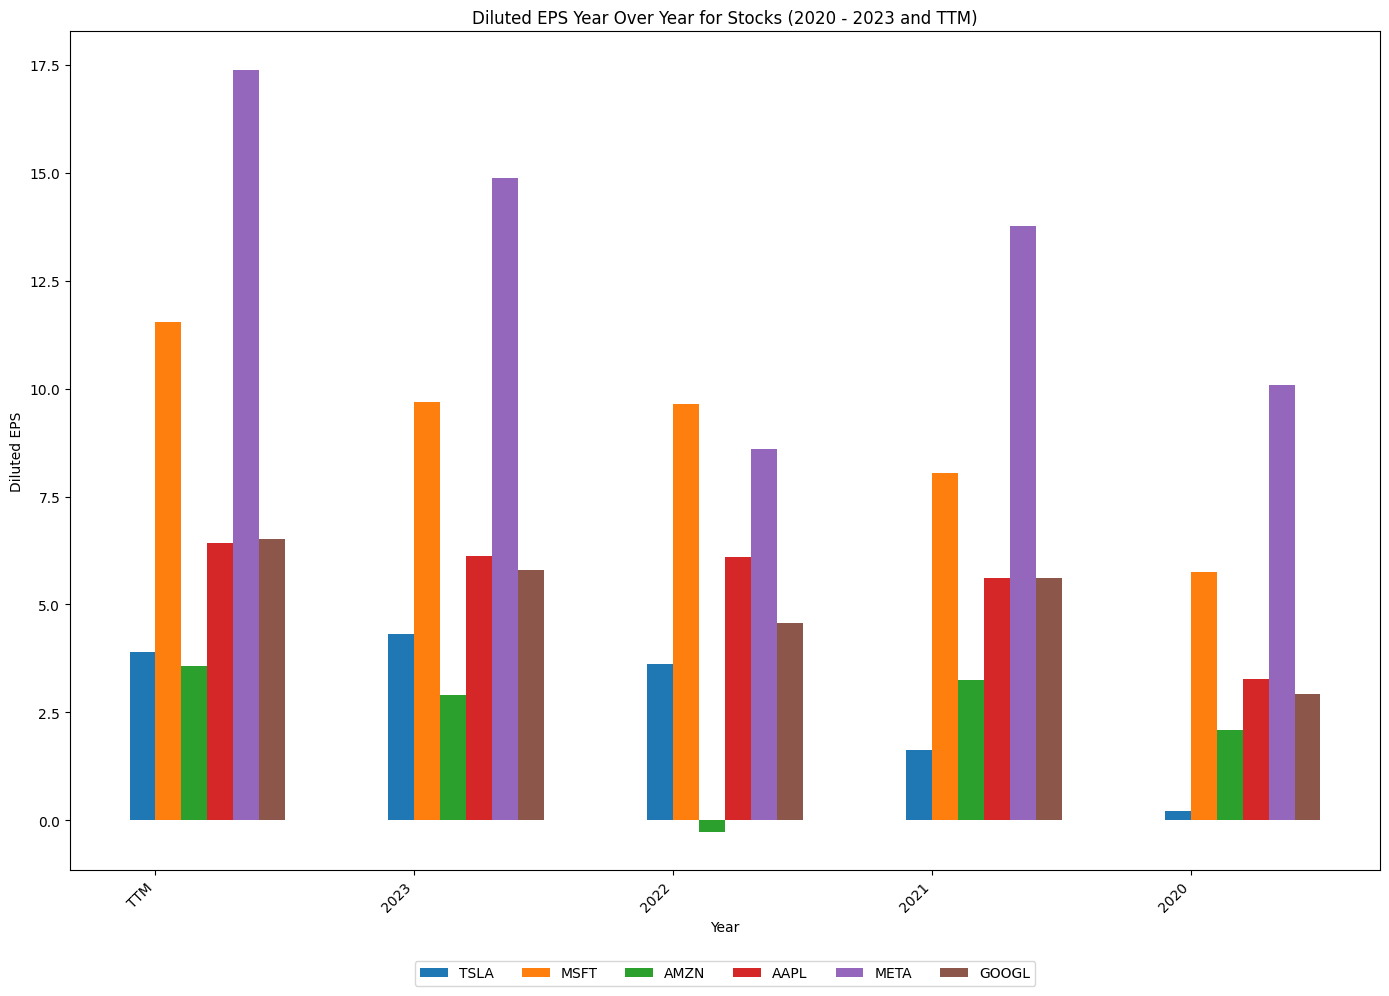

          TSLA   MSFT    AMZN  AAPL   META     GOOGL
TTM        3.9  11.55    3.58  6.43  17.39      6.52
2023      4.31   9.68     2.9  6.13  14.87       5.8
2022      3.62   9.65   -0.27  6.11   8.59      4.56
2021      1.63   8.05  3.2405  5.61  13.77  5.610003
2020  0.213333   5.76  2.0915  3.28  10.09  2.930501


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Function to fetch financial data and calculate EPS year over year
def fetch_eps_history(ticker):
    stock = yf.Ticker(ticker)
    financials = stock.financials.T  # Transpose to get years as rows
    eps = financials['Diluted EPS']
    eps.index = eps.index.year  # Extract year from index
    eps.name = ticker
    # Get TTM EPS
    ttm_eps = stock.info.get('trailingEps', np.nan)
    eps.loc['TTM'] = ttm_eps
    return eps

# Define the tickers of interest
tickers = ['TSLA', 'MSFT', 'AMZN', 'AAPL', 'META', 'GOOGL']

# Fetch EPS history for each ticker
eps_histories = {}
for ticker in tickers:
    eps_histories[ticker] = fetch_eps_history(ticker)

# Combine the EPS histories into a single DataFrame
eps_df = pd.concat(eps_histories.values(), axis=1)

# Filter the DataFrame to include only the years 2020 to 2023
years_of_interest = ['TTM', 2023, 2022, 2021, 2020]
eps_df = eps_df.loc[years_of_interest]

# Plot the EPS year over year as histograms in separate subplots
fig, ax = plt.subplots(figsize=(14, 10))

# Bar width
bar_width = 0.1

# Generate x locations for each group
years = np.arange(len(eps_df.index))

# Plot bars for each ticker
for i, ticker in enumerate(tickers):
    ax.bar(years + i * bar_width, eps_df[ticker], bar_width, label=ticker)

# Adding labels
ax.set_xlabel('Year')
ax.set_ylabel('Diluted EPS')
ax.set_title('Diluted EPS Year Over Year for Stocks (2020 - 2023 and TTM)')
ax.set_xticks(years + bar_width / 2)
ax.set_xticklabels(eps_df.index.astype(str), rotation=45, ha='right')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(tickers))

plt.tight_layout()
plt.show()

# Display the DataFrame
print(eps_df)



# News

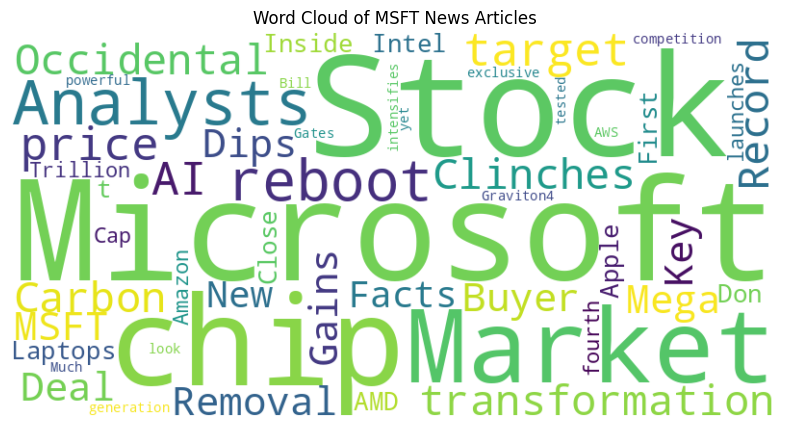

1. Analysts reboot Microsoft stock price target on AI transformation
   Sentiment: neutral
   Link: https://finance.yahoo.com/m/8818f741-5c6c-3d72-82d1-a5b475eac066/analysts-reboot-microsoft.html
2. Occidental Clinches Record Carbon-Removal Deal With Mega-Buyer Microsoft
   Sentiment: neutral
   Link: https://finance.yahoo.com/news/occidental-clinches-record-carbon-removal-214953498.html
3. Microsoft (MSFT) Stock Dips While Market Gains: Key Facts
   Sentiment: neutral
   Link: https://finance.yahoo.com/news/microsoft-msft-stock-dips-while-214518370.html
4. The New Laptops Are Here, and They Don’t Have Intel or AMD Inside
   Sentiment: positive
   Link: https://finance.yahoo.com/m/eb049ca9-54cc-330e-96a0-dcc55d7d38d3/the-new-laptops-are-here%2C-and.html
5. Apple Stock First To Close Above $3.5 Trillion Market Cap
   Sentiment: positive
   Link: https://finance.yahoo.com/m/2ff31544-d3a4-30e6-a600-85dc48067ceb/apple-stock-first-to-close.html
6. Amazon launches its fourth-generation Gravi

In [ ]:
import yfinance as yf
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textblob import TextBlob

# Function to fetch news articles from Yahoo Finance
def fetch_yahoo_news(ticker):
    stock = yf.Ticker(ticker)
    news_articles = stock.news
    return news_articles

# Function to generate word cloud
def generate_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud of {ticker} News Articles')
    plt.show()

# Function to perform sentiment analysis
def analyze_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Function to display top 20 news articles with links and sentiment
def display_top_news(news_articles):
    top_news = news_articles[:20]
    for i, article in enumerate(top_news):
        sentiment = analyze_sentiment(article['title'])
        print(f"{i+1}. {article['title']}")
        print(f"   Sentiment: {sentiment}")
        print(f"   Link: {article['link']}")

# Example usage
# topic = "TSLA"
news_articles = fetch_yahoo_news(ticker)
if news_articles:
    news_text = ' '.join(article['title'] for article in news_articles)
    generate_word_cloud(news_text)
    display_top_news(news_articles)
else:
    print("No news articles found.")

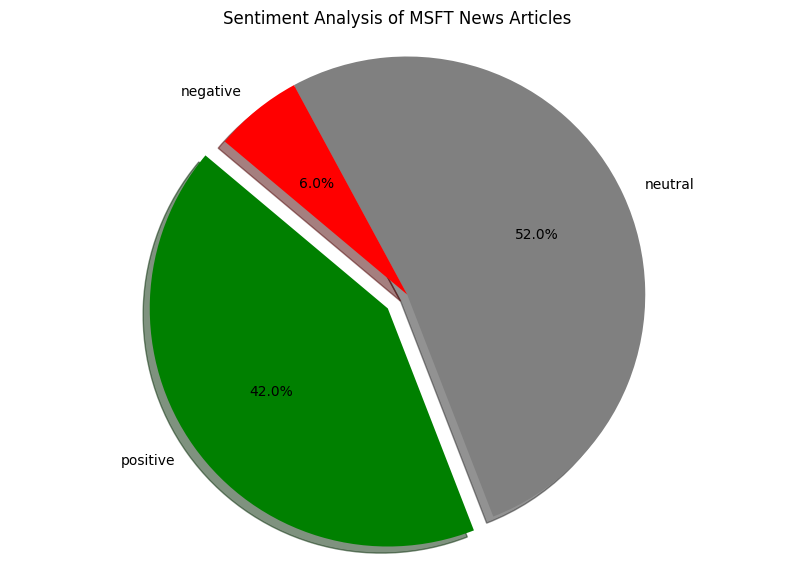

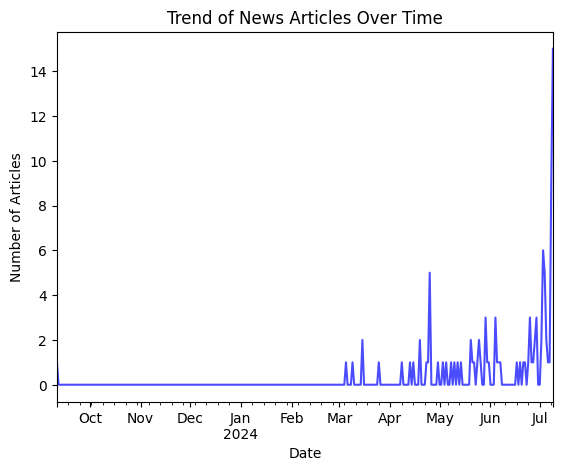

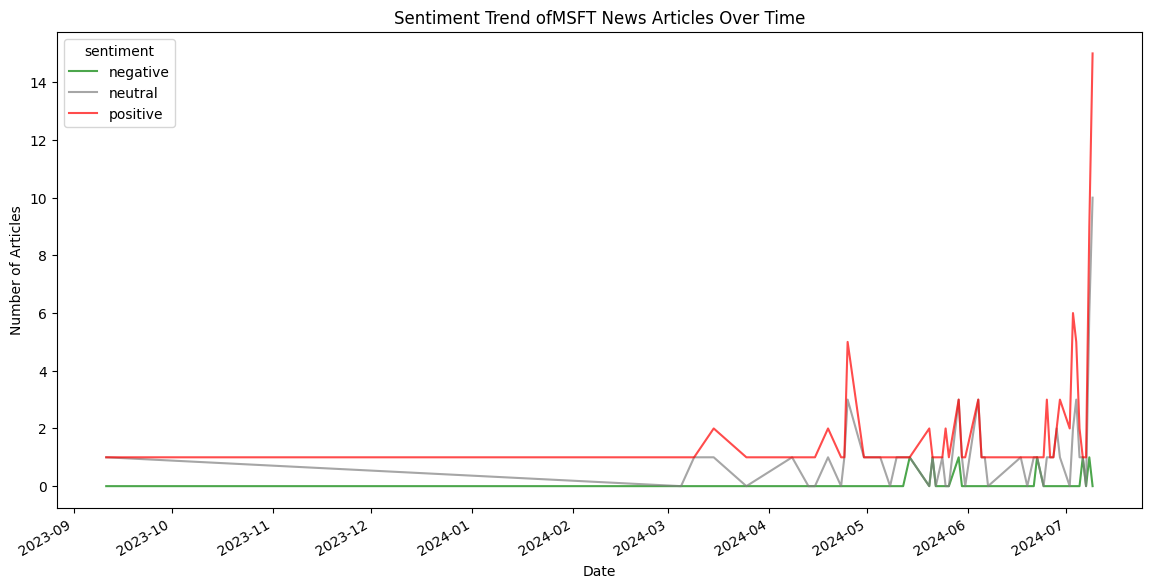

Sentiment Analysis for MSFT news articles:
Positive: 42 articles (42.00%)
Neutral: 52 articles (52.00%)
Negative: 6 articles (6.00%)


In [ ]:
import requests
from bs4 import BeautifulSoup
from textblob import TextBlob
import matplotlib.pyplot as plt
import pandas as pd
import datetime

# Function to fetch news articles
def fetch_news(topic):
    url = f"https://news.google.com/rss/search?q={topic}"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'xml')
    items = soup.find_all('item')
    news_articles = []
    for item in items:
        title = item.title.get_text()
        pub_date = item.pubDate.get_text()
        pub_date = datetime.datetime.strptime(pub_date, '%a, %d %b %Y %H:%M:%S %Z')
        news_articles.append({'title': title, 'pub_date': pub_date})
    return news_articles

# Function to perform sentiment analysis
def analyze_sentiment(news_articles):
    sentiments = {'positive': 0, 'neutral': 0, 'negative': 0}
    trend_data = []
    for article in news_articles:
        blob = TextBlob(article['title'])
        polarity = blob.sentiment.polarity
        if polarity > 0:
            sentiment = 'positive'
            sentiments['positive'] += 1
        elif polarity < 0:
            sentiment = 'negative'
            sentiments['negative'] += 1
        else:
            sentiment = 'neutral'
            sentiments['neutral'] += 1
        trend_data.append({'date': article['pub_date'], 'sentiment': sentiment, 'polarity': polarity})
    return sentiments, trend_data

# Function to plot sentiment analysis results
def plot_sentiment(sentiments, trend_data):
    labels = sentiments.keys()
    sizes = sentiments.values()
    colors = ['green', 'grey', 'red']
    explode = (0.1, 0, 0)  # explode 1st slice (i.e. 'positive')

    plt.figure(figsize=(10, 7))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(f"Sentiment Analysis of {ticker} News Articles")
    plt.show()

    # Trend analysis plot
    trend_df = pd.DataFrame(trend_data)
    trend_df.set_index('date', inplace=True)
    trend_df.resample('D').size().plot(kind='line', color='blue', alpha=0.7)
    plt.title("Trend of News Articles Over Time")
    plt.ylabel("Number of Articles")
    plt.xlabel("Date")
    plt.show()

    sentiment_trend = trend_df.groupby([pd.Grouper(freq='D'), 'sentiment']).size().unstack().fillna(0)
    sentiment_trend.plot(kind='line', stacked=True, figsize=(14, 7), color=['green', 'grey', 'red'], alpha=0.7)
    plt.title(f"Sentiment Trend of{ticker} News Articles Over Time")
    plt.ylabel("Number of Articles")
    plt.xlabel("Date")
    plt.show()

# Example usage
news_articles = fetch_news(ticker)
sentiments, trend_data = analyze_sentiment(news_articles)
plot_sentiment(sentiments, trend_data)

# Display the results
print(f"Sentiment Analysis for {ticker} news articles:")
for sentiment, count in sentiments.items():
    print(f"{sentiment.capitalize()}: {count} articles ({(count / sum(sentiments.values())) * 100:.2f}%)")



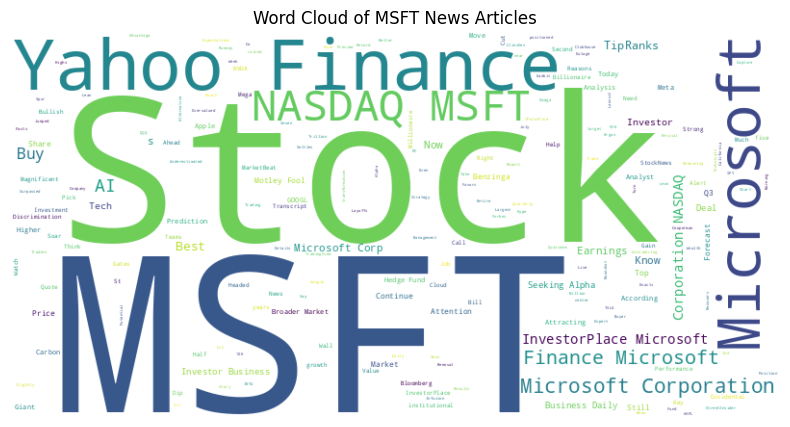

In [ ]:
import requests
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to fetch news articles
def fetch_news(topic):
    url = f"https://news.google.com/rss/search?q={topic}"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'xml')
    items = soup.find_all('item')
    news_articles = []
    for item in items:
        title = item.title.get_text()
        news_articles.append(title)
    return news_articles

# Function to generate word cloud
def generate_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud of {ticker} News Articles')
    plt.show()

# Example usage
news_articles = fetch_news(ticker)
news_text = ' '.join(news_articles)
generate_word_cloud(news_text)

# Stock Analysis

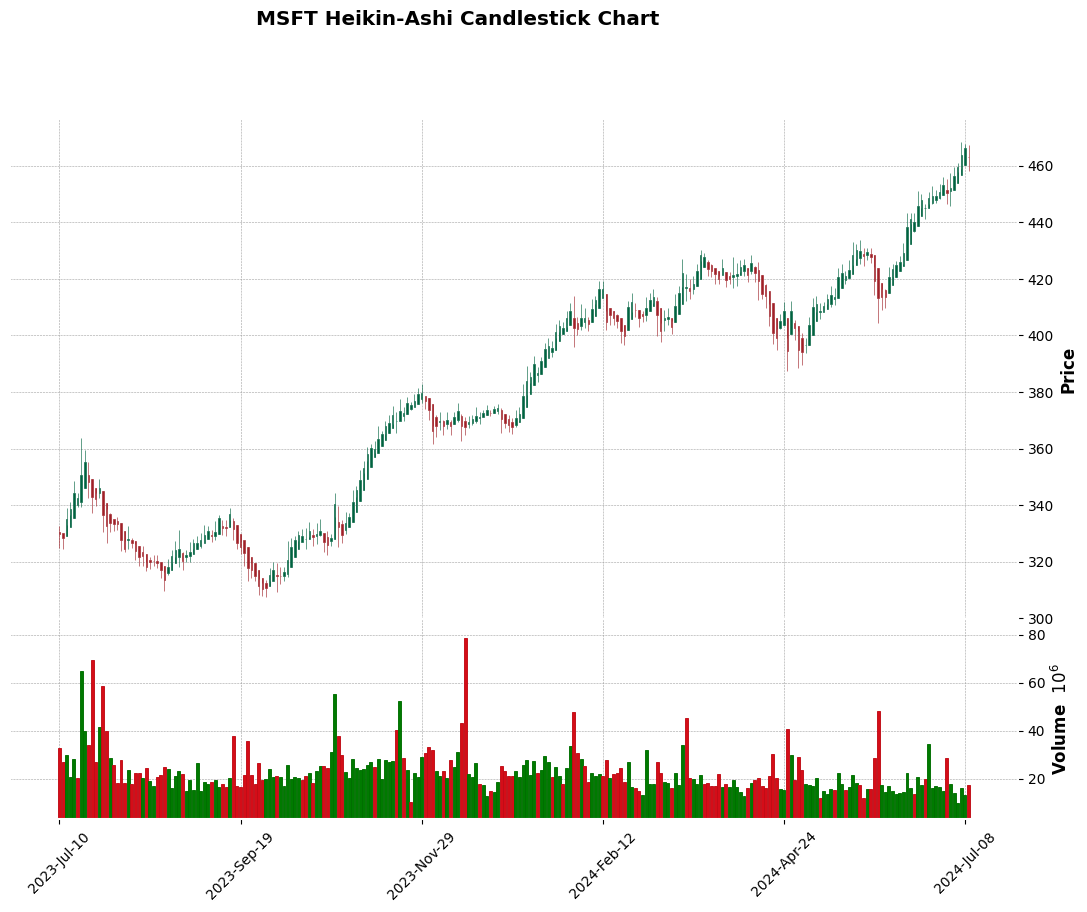

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

# Function to fetch historical stock data
def fetch_historical_stock_data(ticker):
    stock = yf.Ticker(ticker)
    hist = stock.history(period="1y")
    return hist

# Function to calculate Heikin-Ashi values
def calculate_heikin_ashi(data):
    ha_data = data.copy()

    ha_data['HA_Close'] = (data['Open'] + data['High'] + data['Low'] + data['Close']) / 4
    ha_data['HA_Open'] = (data['Open'] + data['Close']) / 2
    ha_data['HA_High'] = data[['High', 'Open', 'Close']].max(axis=1)
    ha_data['HA_Low'] = data[['Low', 'Open', 'Close']].min(axis=1)

    for i in range(1, len(ha_data)):
        ha_data['HA_Open'].iat[i] = (ha_data['HA_Open'].iat[i-1] + ha_data['HA_Close'].iat[i-1]) / 2

    ha_data = ha_data[['HA_Open', 'HA_High', 'HA_Low', 'HA_Close']]
    ha_data.columns = ['Open', 'High', 'Low', 'Close']
    ha_data['Volume'] = data['Volume']

    return ha_data

# Function to plot Heikin-Ashi candlestick chart
def plot_heikin_ashi(data, ticker):
    mpf.plot(data, type='candle', style='charles', title=f'{ticker} Heikin-Ashi Candlestick Chart', ylabel='Price', volume=True, figsize=(14, 10))

# Example usage
data = fetch_historical_stock_data(ticker)
ha_data = calculate_heikin_ashi(data)
plot_heikin_ashi(ha_data, ticker)


Latest RSI: 64.20287613431194
Latest MACD: 9.671603645768243
Latest MACD Signal: 9.02065242794733
Latest MACD Diff: 0.6509512178209143


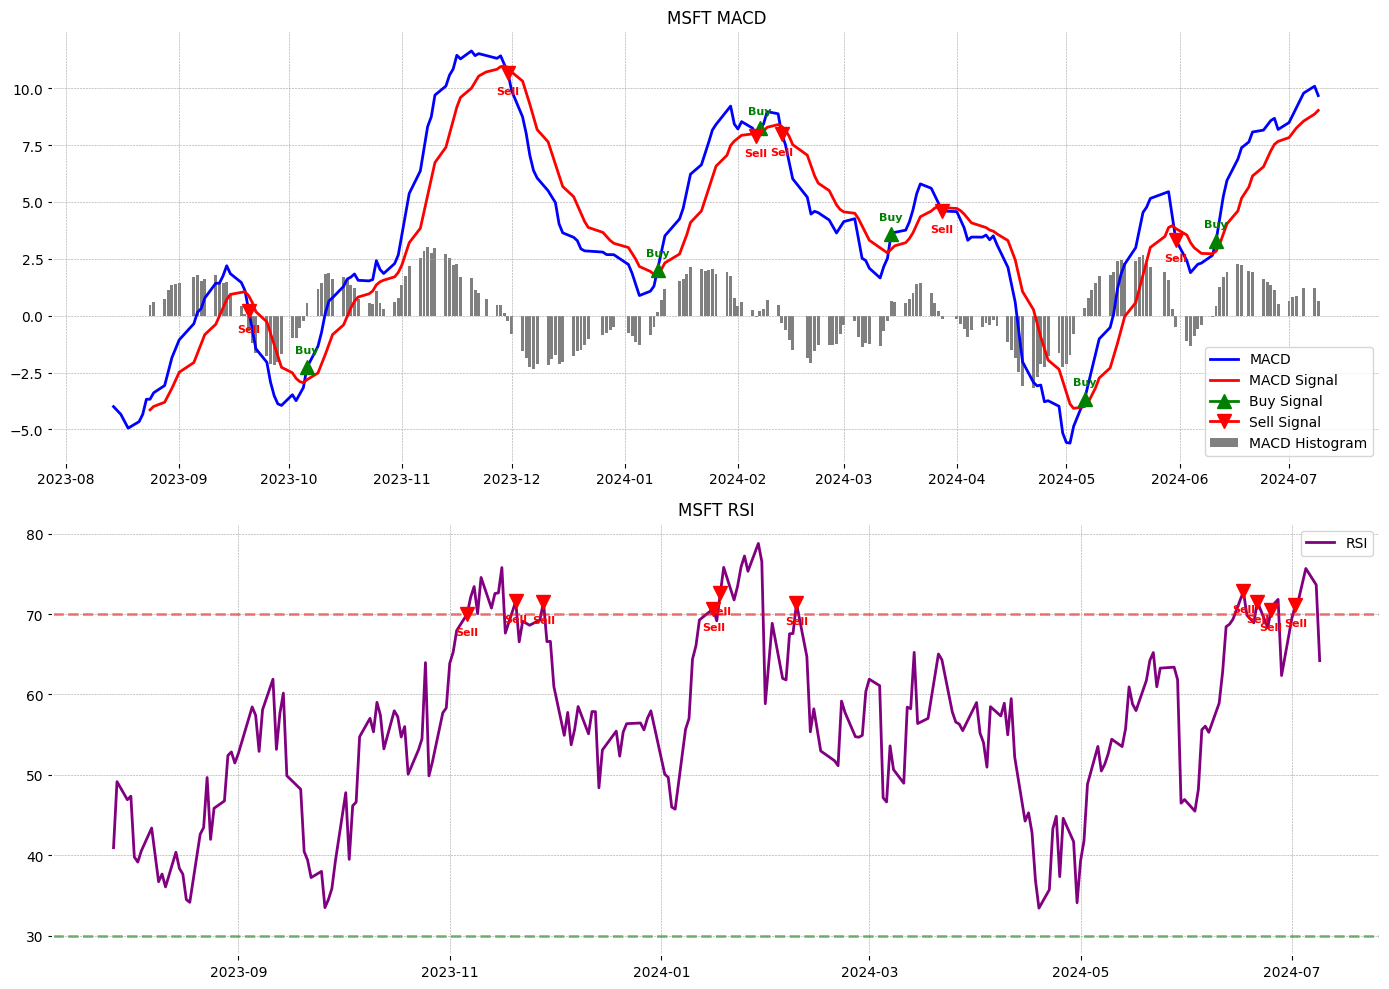

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import ta

# Function to fetch historical stock data
def fetch_historical_stock_data(ticker):
    stock = yf.Ticker(ticker)
    hist = stock.history(period="1y")
    return hist

# Function to calculate MACD and RSI
def calculate_macd_rsi(data):
    # Calculate MACD
    macd = ta.trend.MACD(data['Close'])
    data['MACD'] = macd.macd()
    data['MACD_Signal'] = macd.macd_signal()
    data['MACD_Hist'] = macd.macd_diff()

    # Calculate RSI
    rsi = ta.momentum.RSIIndicator(data['Close'])
    data['RSI'] = rsi.rsi()

    return data

# Function to determine buy and sell signals based on MACD and RSI
def calculate_signals(data):
    buy_signals = []
    sell_signals = []

    for i in range(1, len(data)):
        # Buy signal for MACD
        if data['MACD'][i] > data['MACD_Signal'][i] and data['MACD'][i-1] <= data['MACD_Signal'][i-1]:
            buy_signals.append((data.index[i], data['MACD'][i], 'MACD'))
        # Sell signal for MACD
        if data['MACD'][i] < data['MACD_Signal'][i] and data['MACD'][i-1] >= data['MACD_Signal'][i-1]:
            sell_signals.append((data.index[i], data['MACD'][i], 'MACD'))
        # Buy signal for RSI
        if data['RSI'][i] < 30 and data['RSI'][i-1] >= 30:
            buy_signals.append((data.index[i], data['RSI'][i], 'RSI'))
        # Sell signal for RSI
        if data['RSI'][i] > 70 and data['RSI'][i-1] <= 70:
            sell_signals.append((data.index[i], data['RSI'][i], 'RSI'))

    return buy_signals, sell_signals

# Function to plot MACD and RSI with buy and sell signals
def plot_macd_rsi(data, ticker, buy_signals, sell_signals):
    # Print latest values
    latest_rsi = data['RSI'].iloc[-1]
    latest_macd = data['MACD'].iloc[-1]
    latest_macd_signal = data['MACD_Signal'].iloc[-1]
    latest_macd_diff = data['MACD_Hist'].iloc[-1]

    print(f'Latest RSI: {latest_rsi}')
    print(f'Latest MACD: {latest_macd}')
    print(f'Latest MACD Signal: {latest_macd_signal}')
    print(f'Latest MACD Diff: {latest_macd_diff}')

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 1]})

    # Plot MACD
    ax1.plot(data.index, data['MACD'], label='MACD', color='blue')
    ax1.plot(data.index, data['MACD_Signal'], label='MACD Signal', color='red')
    ax1.bar(data.index, data['MACD_Hist'], label='MACD Histogram', color='gray')

    # Plot buy and sell signals on MACD chart
    for signal in buy_signals:
        if signal[2] == 'MACD':
            ax1.plot(signal[0], signal[1], marker='^', color='green', markersize=10, label='Buy Signal' if signal == buy_signals[0] else "")
            ax1.annotate('Buy', (signal[0], signal[1]), textcoords="offset points", xytext=(0,10), ha='center', color='green', fontsize=8, weight='bold')
    for signal in sell_signals:
        if signal[2] == 'MACD':
            ax1.plot(signal[0], signal[1], marker='v', color='red', markersize=10, label='Sell Signal' if signal == sell_signals[0] else "")
            ax1.annotate('Sell', (signal[0], signal[1]), textcoords="offset points", xytext=(0,-15), ha='center', color='red', fontsize=8, weight='bold')

    ax1.set_title(f'{ticker} MACD')
    ax1.legend()
    ax1.grid(True)

    # Plot RSI
    ax2.plot(data.index, data['RSI'], label='RSI', color='purple')
    ax2.axhline(70, linestyle='--', alpha=0.5, color='red')
    ax2.axhline(30, linestyle='--', alpha=0.5, color='green')

    # Plot buy and sell signals on RSI chart
    for signal in buy_signals:
        if signal[2] == 'RSI':
            ax2.plot(signal[0], signal[1], marker='^', color='green', markersize=10, label='Buy Signal' if signal == buy_signals[0] else "")
            ax2.annotate('Buy', (signal[0], signal[1]), textcoords="offset points", xytext=(0,10), ha='center', color='green', fontsize=8, weight='bold')
    for signal in sell_signals:
        if signal[2] == 'RSI':
            ax2.plot(signal[0], signal[1], marker='v', color='red', markersize=10, label='Sell Signal' if signal == sell_signals[0] else "")
            ax2.annotate('Sell', (signal[0], signal[1]), textcoords="offset points", xytext=(0,-15), ha='center', color='red', fontsize=8, weight='bold')

    ax2.set_title(f'{ticker} RSI')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
data = fetch_historical_stock_data(ticker)
data = calculate_macd_rsi(data)
buy_signals, sell_signals = calculate_signals(data)
plot_macd_rsi(data, ticker, buy_signals, sell_signals)




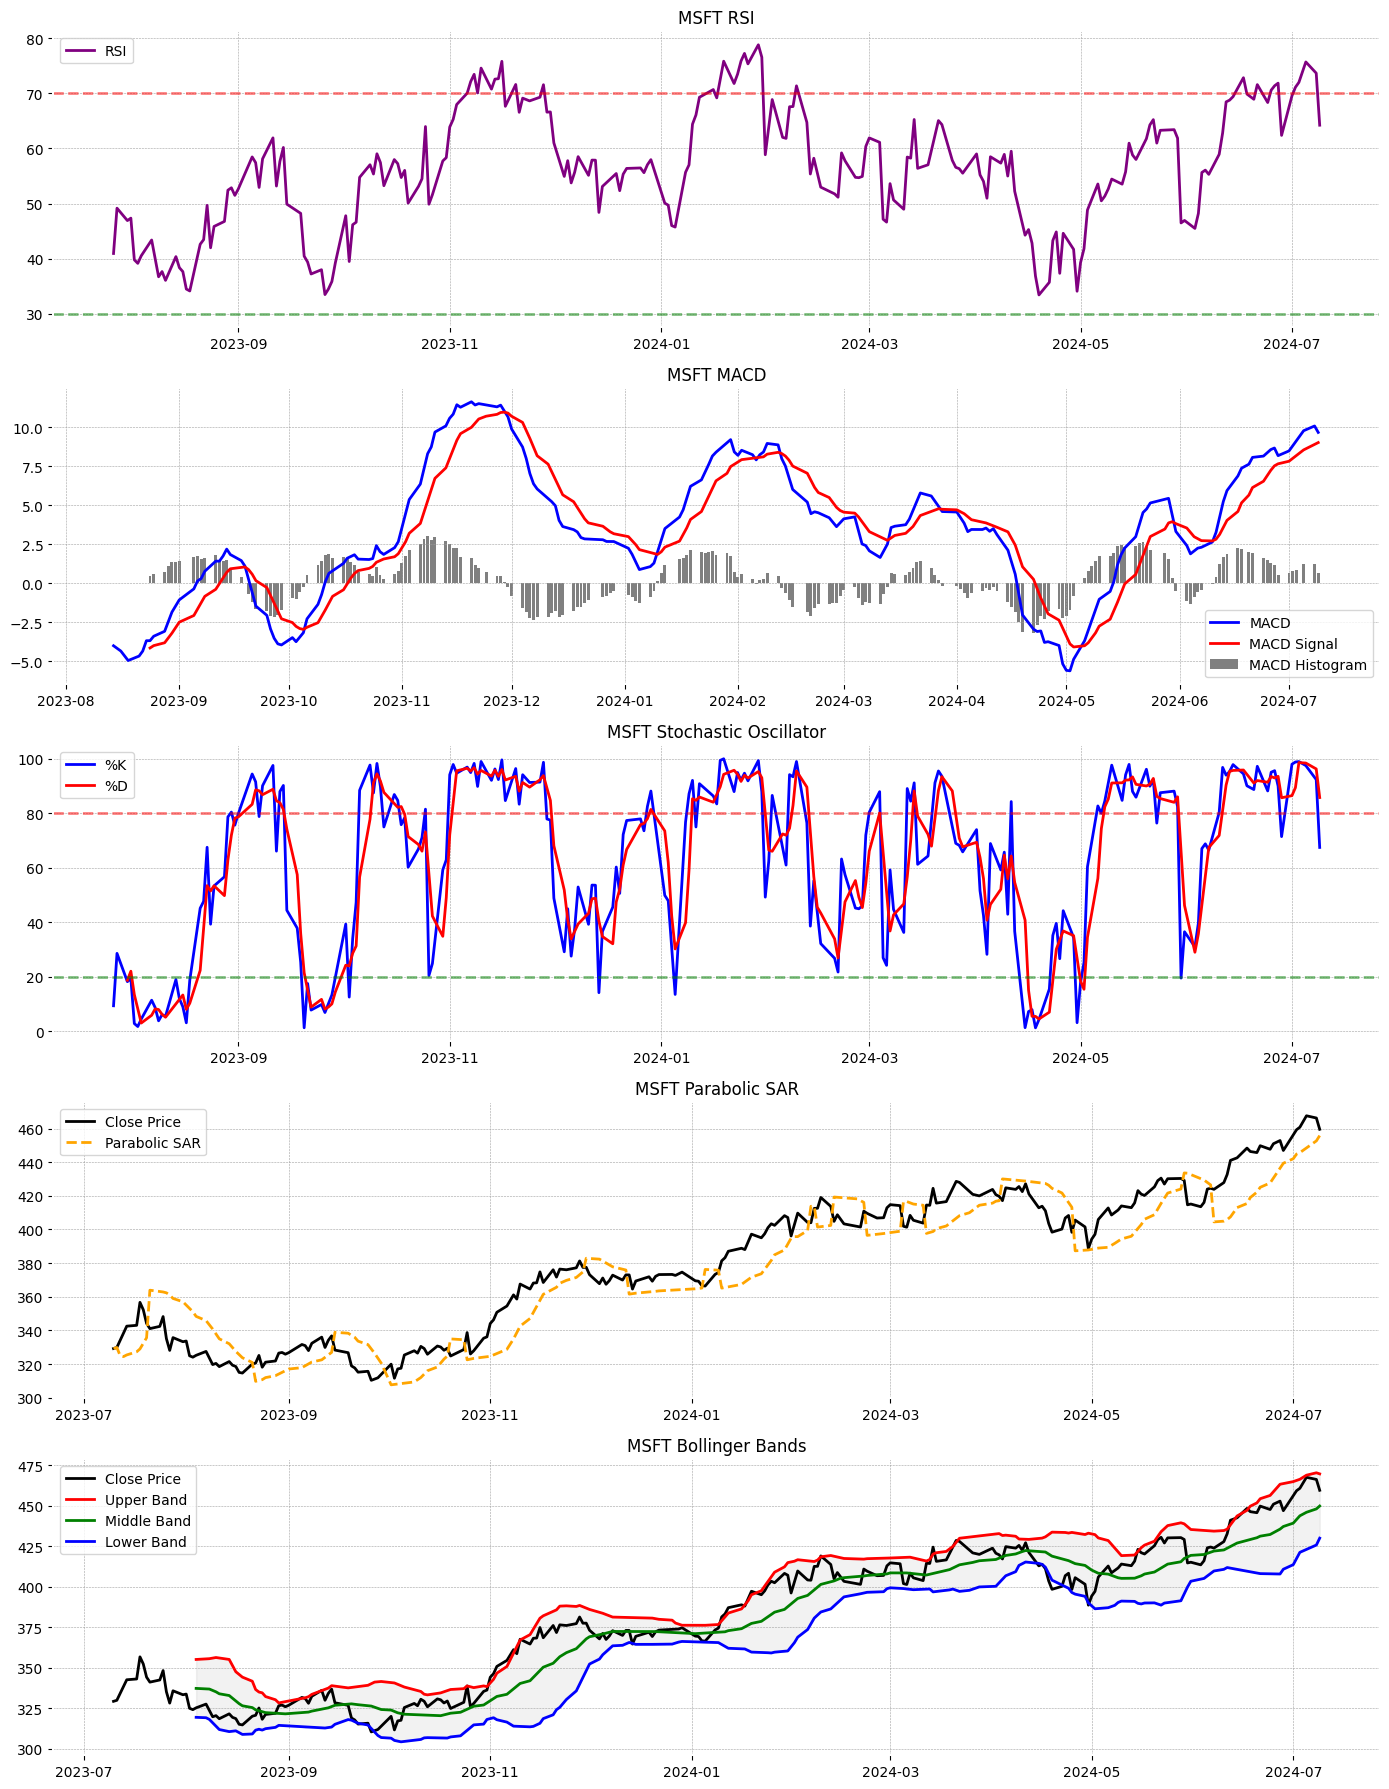

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import ta

# Function to fetch historical stock data
def fetch_historical_stock_data(ticker):
    stock = yf.Ticker(ticker)
    hist = stock.history(period="1y")
    return hist

# Function to calculate trend reversal indicators
def calculate_indicators(data):
    # Calculate RSI
    rsi = ta.momentum.RSIIndicator(data['Close'])
    data['RSI'] = rsi.rsi()

    # Calculate MACD
    macd = ta.trend.MACD(data['Close'])
    data['MACD'] = macd.macd()
    data['MACD_Signal'] = macd.macd_signal()
    data['MACD_Hist'] = macd.macd_diff()

    # Calculate Stochastic Oscillator
    stochastic = ta.momentum.StochasticOscillator(data['High'], data['Low'], data['Close'])
    data['Stoch_K'] = stochastic.stoch()
    data['Stoch_D'] = stochastic.stoch_signal()

    # Calculate Parabolic SAR
    parabolic_sar = ta.trend.PSARIndicator(data['High'], data['Low'], data['Close'])
    data['Parabolic_SAR'] = parabolic_sar.psar()

    # Calculate Bollinger Bands
    bollinger = ta.volatility.BollingerBands(data['Close'])
    data['BB_Upper'] = bollinger.bollinger_hband()
    data['BB_Lower'] = bollinger.bollinger_lband()
    data['BB_Middle'] = bollinger.bollinger_mavg()

    return data

# Function to plot trend reversal indicators
def plot_indicators(data, ticker):
    fig, axs = plt.subplots(5, 1, figsize=(14, 18), gridspec_kw={'height_ratios': [1, 1, 1, 1, 1]})

    # Plot RSI
    axs[0].plot(data.index, data['RSI'], label='RSI', color='purple')
    axs[0].axhline(70, linestyle='--', alpha=0.5, color='red')
    axs[0].axhline(30, linestyle='--', alpha=0.5, color='green')
    axs[0].set_title(f'{ticker} RSI')
    axs[0].legend()
    axs[0].grid(True)

    # Plot MACD
    axs[1].plot(data.index, data['MACD'], label='MACD', color='blue')
    axs[1].plot(data.index, data['MACD_Signal'], label='MACD Signal', color='red')
    axs[1].bar(data.index, data['MACD_Hist'], label='MACD Histogram', color='gray')
    axs[1].set_title(f'{ticker} MACD')
    axs[1].legend()
    axs[1].grid(True)

    # Plot Stochastic Oscillator
    axs[2].plot(data.index, data['Stoch_K'], label='%K', color='blue')
    axs[2].plot(data.index, data['Stoch_D'], label='%D', color='red')
    axs[2].axhline(80, linestyle='--', alpha=0.5, color='red')
    axs[2].axhline(20, linestyle='--', alpha=0.5, color='green')
    axs[2].set_title(f'{ticker} Stochastic Oscillator')
    axs[2].legend()
    axs[2].grid(True)

    # Plot Parabolic SAR
    axs[3].plot(data.index, data['Close'], label='Close Price', color='black')
    axs[3].plot(data.index, data['Parabolic_SAR'], label='Parabolic SAR', linestyle='--', color='orange')
    axs[3].set_title(f'{ticker} Parabolic SAR')
    axs[3].legend()
    axs[3].grid(True)

    # Plot Bollinger Bands
    axs[4].plot(data.index, data['Close'], label='Close Price', color='black')
    axs[4].plot(data.index, data['BB_Upper'], label='Upper Band', color='red')
    axs[4].plot(data.index, data['BB_Middle'], label='Middle Band', color='green')
    axs[4].plot(data.index, data['BB_Lower'], label='Lower Band', color='blue')
    axs[4].fill_between(data.index, data['BB_Upper'], data['BB_Lower'], color='gray', alpha=0.1)
    axs[4].set_title(f'{ticker} Bollinger Bands')
    axs[4].legend()
    axs[4].grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
data = fetch_historical_stock_data(ticker)
data = calculate_indicators(data)
plot_indicators(data, ticker)


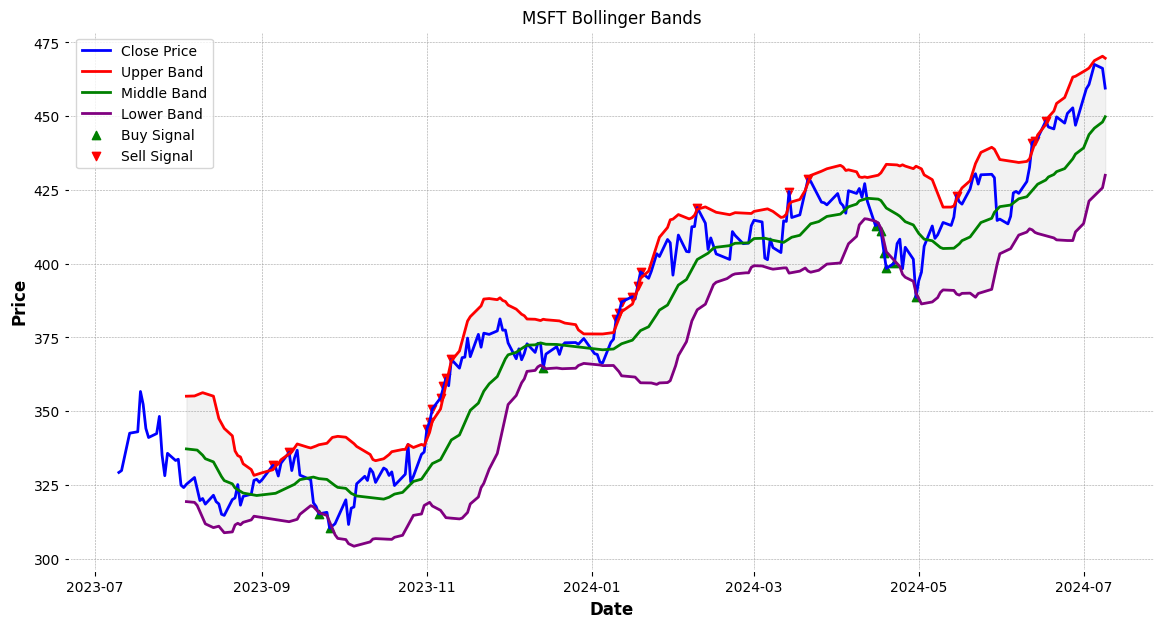

In [ ]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt

# Function to fetch historical stock data
def fetch_historical_stock_data(ticker, period="1y"):
    stock = yf.Ticker(ticker)
    hist = stock.history(period=period)
    return hist

# Function to calculate Bollinger Bands
def calculate_bollinger_bands(data, window=20, std_dev=2):
    bb = ta.bbands(data['Close'], length=window, std=std_dev)
    data['BB_Upper'] = bb['BBU_20_2.0']
    data['BB_Middle'] = bb['BBM_20_2.0']
    data['BB_Lower'] = bb['BBL_20_2.0']
    return data

# Function to identify buy and sell signals
def identify_buy_sell_signals(data):
    data['Buy_Signal'] = (data['Close'] < data['BB_Lower'])
    data['Sell_Signal'] = (data['Close'] > data['BB_Upper'])
    return data

# Function to plot Bollinger Bands with buy and sell signals
def plot_bollinger_bands(data, ticker):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['Close'], label='Close Price', color='blue')
    plt.plot(data.index, data['BB_Upper'], label='Upper Band', color='red')
    plt.plot(data.index, data['BB_Middle'], label='Middle Band', color='green')
    plt.plot(data.index, data['BB_Lower'], label='Lower Band', color='purple')

    # Shade the area between the upper and lower Bollinger Bands
    plt.fill_between(data.index, data['BB_Upper'], data['BB_Lower'], color='gray', alpha=0.1)

    # Plot buy signals
    plt.scatter(data.index[data['Buy_Signal']], data['Close'][data['Buy_Signal']], label='Buy Signal', marker='^', color='green', alpha=1)

    # Plot sell signals
    plt.scatter(data.index[data['Sell_Signal']], data['Close'][data['Sell_Signal']], label='Sell Signal', marker='v', color='red', alpha=1)

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{ticker} Bollinger Bands')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
data = fetch_historical_stock_data(ticker)
data = calculate_bollinger_bands(data)
data = identify_buy_sell_signals(data)
plot_bollinger_bands(data, ticker)


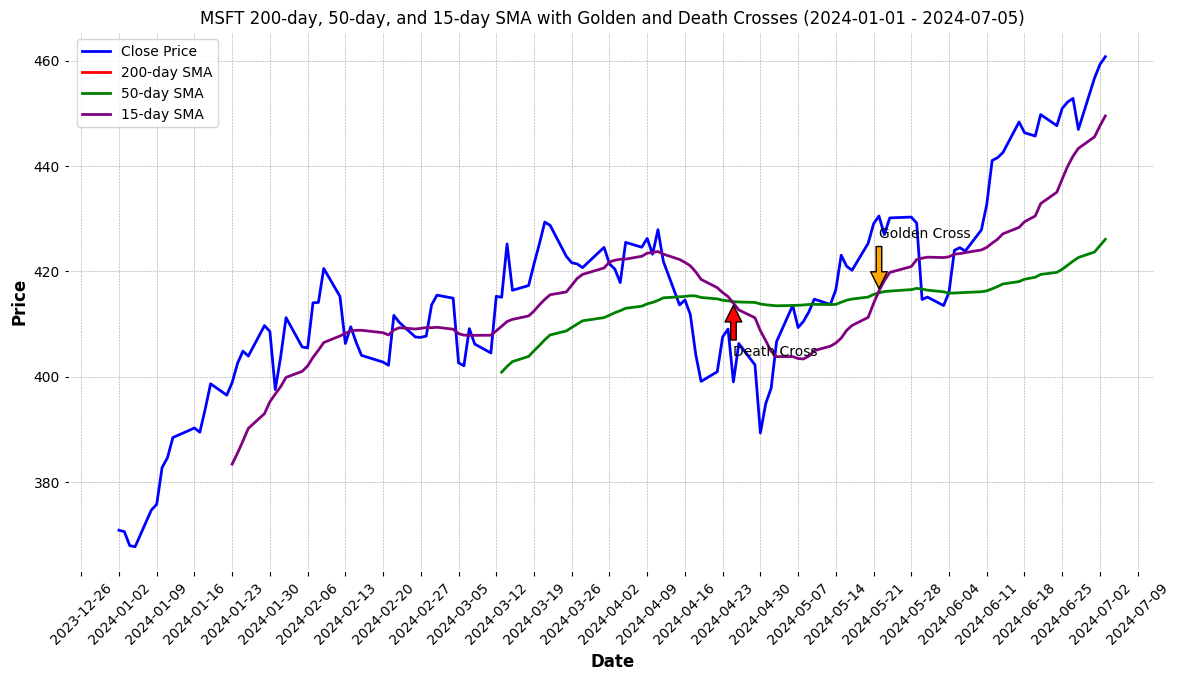

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator

# Calculate SMAs
filtered_data_stock['15-day SMA'] = filtered_data_stock['Close'].rolling(window=15).mean()
filtered_data_stock['50-day SMA'] = filtered_data_stock['Close'].rolling(window=50).mean()
filtered_data_stock['200-day SMA'] = filtered_data_stock['Close'].rolling(window=200).mean()

# Plot the 200-day, 50-day, and 15-day SMA
plt.figure(figsize=(14, 7))
plt.plot(filtered_data_stock['Date'], filtered_data_stock['Close'], label='Close Price', color='blue')
plt.plot(filtered_data_stock['Date'], filtered_data_stock['200-day SMA'], label='200-day SMA', color='red')
plt.plot(filtered_data_stock['Date'], filtered_data_stock['50-day SMA'], label='50-day SMA', color='green')
plt.plot(filtered_data_stock['Date'], filtered_data_stock['15-day SMA'], label='15-day SMA', color='purple')

# Identify and label the golden cross and death cross points
for i in range(1, len(filtered_data_stock)):
    if (filtered_data_stock['15-day SMA'].iloc[i] > filtered_data_stock['50-day SMA'].iloc[i] and
        filtered_data_stock['15-day SMA'].iloc[i-1] <= filtered_data_stock['50-day SMA'].iloc[i-1]):
        plt.annotate('Golden Cross', xy=(filtered_data_stock['Date'].iloc[i], filtered_data_stock['15-day SMA'].iloc[i]),
                     xytext=(filtered_data_stock['Date'].iloc[i], filtered_data_stock['15-day SMA'].iloc[i]+10),
                     arrowprops=dict(facecolor='orange', shrink=0.05))

    if (filtered_data_stock['15-day SMA'].iloc[i] < filtered_data_stock['50-day SMA'].iloc[i] and
        filtered_data_stock['15-day SMA'].iloc[i-1] >= filtered_data_stock['50-day SMA'].iloc[i-1]):
        plt.annotate('Death Cross', xy=(filtered_data_stock['Date'].iloc[i], filtered_data_stock['15-day SMA'].iloc[i]),
                     xytext=(filtered_data_stock['Date'].iloc[i], filtered_data_stock['15-day SMA'].iloc[i]-10),
                     arrowprops=dict(facecolor='red', shrink=0.05))

plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{ticker} 200-day, 50-day, and 15-day SMA with Golden and Death Crosses ({start_date} - {end_date})')
plt.legend()


# Improve the x-axis labels using mdates
plt.gca().xaxis.set_major_locator(WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Golden Crosses: DatetimeIndex([], dtype='datetime64[ns, America/New_York]', name='Date', freq=None)
Death Crosses: DatetimeIndex([], dtype='datetime64[ns, America/New_York]', name='Date', freq=None)


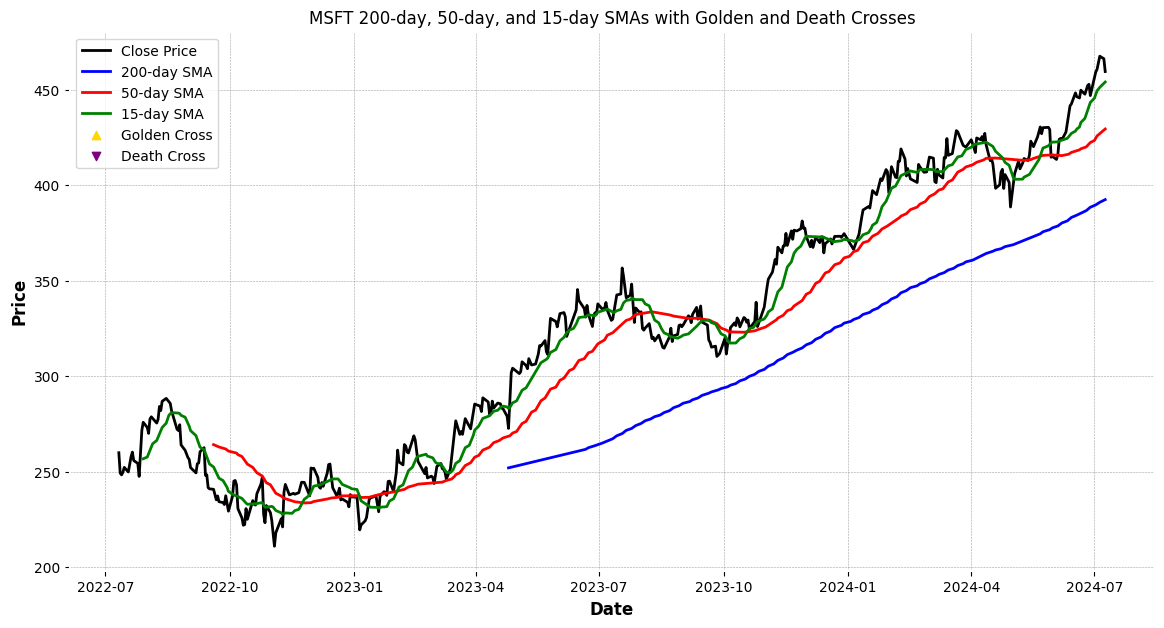

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Function to fetch historical stock data
def fetch_historical_stock_data(ticker, period="2y"):
    stock = yf.Ticker(ticker)
    hist = stock.history(period=period)
    return hist

# Function to calculate SMAs
def calculate_smas(data):
    data['SMA_200'] = data['Close'].rolling(window=200).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['SMA_15'] = data['Close'].rolling(window=15).mean()
    return data

# Function to identify golden and death crosses
def identify_crosses(data):
    data['Golden_Cross'] = ((data['SMA_50'] > data['SMA_200']) & (data['SMA_50'].shift(1) <= data['SMA_200'].shift(1)))
    data['Death_Cross'] = ((data['SMA_50'] < data['SMA_200']) & (data['SMA_50'].shift(1) >= data['SMA_200'].shift(1)))
    return data

# Function to plot SMAs with golden and death crosses
def plot_smas_with_crosses(data, ticker):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['Close'], label='Close Price', color='black')
    plt.plot(data.index, data['SMA_200'], label='200-day SMA', color='blue')
    plt.plot(data.index, data['SMA_50'], label='50-day SMA', color='red')
    plt.plot(data.index, data['SMA_15'], label='15-day SMA', color='green')

    # Plot golden crosses
    golden_crosses = data[data['Golden_Cross']]
    print("Golden Crosses:", golden_crosses.index)
    plt.scatter(golden_crosses.index, golden_crosses['Close'], label='Golden Cross', marker='^', color='gold', alpha=1)

    for idx in golden_crosses.index:
        plt.annotate('Golden Cross', xy=(idx, data.loc[idx, 'Close']),
                     xytext=(idx, data.loc[idx, 'Close'] + 10),
                     arrowprops=dict(facecolor='orange', shrink=0.05))

    # Plot death crosses
    death_crosses = data[data['Death_Cross']]
    print("Death Crosses:", death_crosses.index)
    plt.scatter(death_crosses.index, death_crosses['Close'], label='Death Cross', marker='v', color='purple', alpha=1)

    for idx in death_crosses.index:
        plt.annotate('Death Cross', xy=(idx, data.loc[idx, 'Close']),
                     xytext=(idx, data.loc[idx, 'Close'] - 10),
                     arrowprops=dict(facecolor='red', shrink=0.05))

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{ticker} 200-day, 50-day, and 15-day SMAs with Golden and Death Crosses')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
data = fetch_historical_stock_data(ticker, period="2y")
data = calculate_smas(data)
data = identify_crosses(data)
plot_smas_with_crosses(data, ticker)


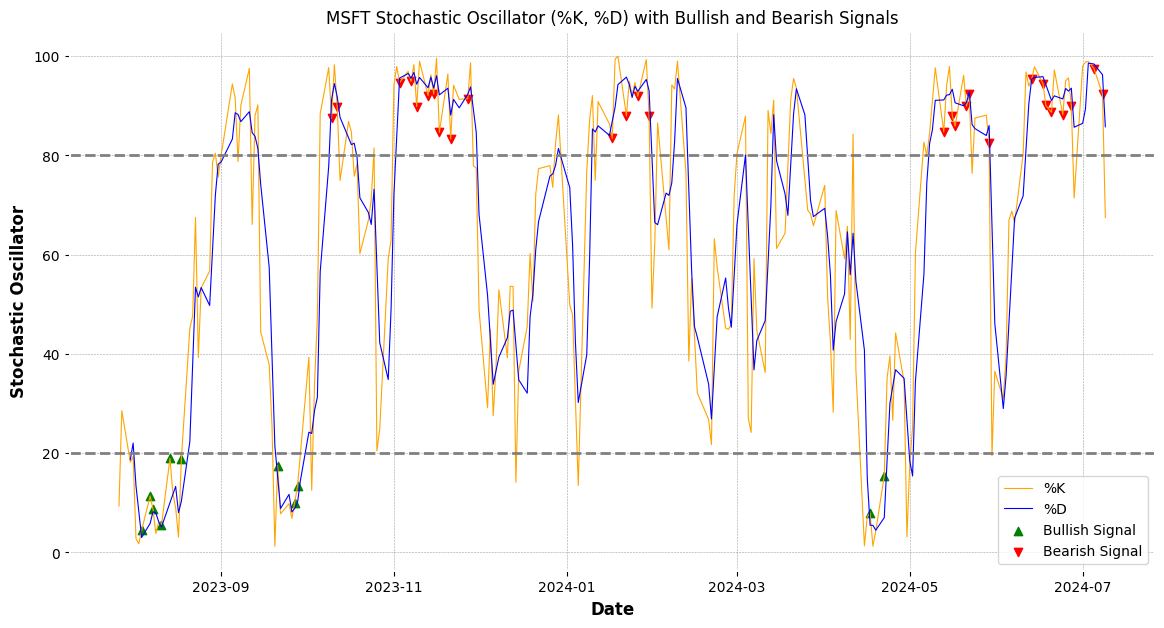

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Function to fetch historical stock data
def fetch_historical_stock_data(ticker, period="1y"):
    stock = yf.Ticker(ticker)
    hist = stock.history(period=period)
    return hist

# Function to calculate Stochastic Oscillator
def calculate_stochastic_oscillator(data, k_period=14, d_period=3):
    data['L14'] = data['Low'].rolling(window=k_period).min()
    data['H14'] = data['High'].rolling(window=k_period).max()
    data['%K'] = 100 * ((data['Close'] - data['L14']) / (data['H14'] - data['L14']))
    data['%D'] = data['%K'].rolling(window=d_period).mean()
    return data

# Function to identify bullish and bearish signals
def identify_stochastic_signals(data):
    data['Bullish_Signal'] = (data['%K'] < 20) & (data['%K'] > data['%D'])
    data['Bearish_Signal'] = (data['%K'] > 80) & (data['%K'] < data['%D'])
    return data

# Function to plot Stochastic Oscillator with signals
def plot_stochastic_oscillator(data, ticker):
    plt.figure(figsize=(14, 7))

    # Plot %K and %D
    plt.plot(data.index, data['%K'], label='%K', color='orange', linewidth=0.8)
    plt.plot(data.index, data['%D'], label='%D', color='blue', linewidth=0.8)

    # Plot bullish signals
    bullish_signals = data[data['Bullish_Signal']]
    plt.scatter(bullish_signals.index, bullish_signals['%K'], label='Bullish Signal', marker='^', color='green', alpha=1)

    # Plot bearish signals
    bearish_signals = data[data['Bearish_Signal']]
    plt.scatter(bearish_signals.index, bearish_signals['%K'], label='Bearish Signal', marker='v', color='red', alpha=1)

    plt.axhline(80, color='grey', linestyle='--')
    plt.axhline(20, color='grey', linestyle='--')

    plt.xlabel('Date')
    plt.ylabel('Stochastic Oscillator')
    plt.title(f'{ticker} Stochastic Oscillator (%K, %D) with Bullish and Bearish Signals')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
data = fetch_historical_stock_data(ticker, period="1y")
data = calculate_stochastic_oscillator(data)
data = identify_stochastic_signals(data)
plot_stochastic_oscillator(data, ticker)


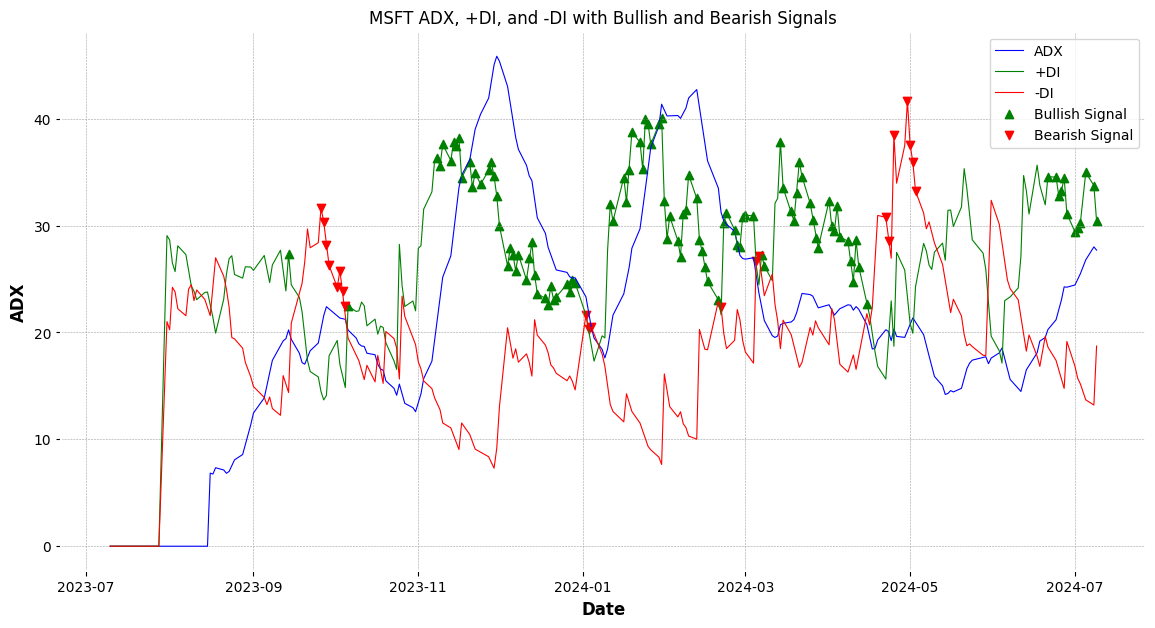

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ta.trend import ADXIndicator

# Function to fetch historical stock data
def fetch_historical_stock_data(ticker, period="1y"):
    stock = yf.Ticker(ticker)
    hist = stock.history(period=period)
    return hist

# Function to calculate ADX, +DI, -DI
def calculate_adx(data, window=14):
    adx_indicator = ADXIndicator(high=data['High'], low=data['Low'], close=data['Close'], window=window)
    data['ADX'] = adx_indicator.adx()
    data['+DI'] = adx_indicator.adx_pos()
    data['-DI'] = adx_indicator.adx_neg()
    return data

# Function to identify bullish and bearish signals
def identify_adx_signals(data):
    data['Bullish_Signal'] = (data['+DI'] > data['-DI']) & (data['ADX'] > 20)
    data['Bearish_Signal'] = (data['-DI'] > data['+DI']) & (data['ADX'] > 20)
    return data

# Function to plot ADX, +DI, -DI with signals
def plot_adx(data, ticker):
    plt.figure(figsize=(14, 7))

    plt.plot(data.index, data['ADX'], label='ADX', color='blue', linewidth=0.8)
    plt.plot(data.index, data['+DI'], label='+DI', color='green', linewidth=0.8)
    plt.plot(data.index, data['-DI'], label='-DI', color='red', linewidth=0.8)

    # Plot bullish signals
    bullish_signals = data[data['Bullish_Signal']]
    plt.scatter(bullish_signals.index, bullish_signals['+DI'], label='Bullish Signal', marker='^', color='green', alpha=1)

    # Plot bearish signals
    bearish_signals = data[data['Bearish_Signal']]
    plt.scatter(bearish_signals.index, bearish_signals['-DI'], label='Bearish Signal', marker='v', color='red', alpha=1)

    plt.xlabel('Date')
    plt.ylabel('ADX')
    plt.title(f'{ticker} ADX, +DI, and -DI with Bullish and Bearish Signals')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Example usage
data = fetch_historical_stock_data(ticker, period="1y")
data = calculate_adx(data)
data = identify_adx_signals(data)
plot_adx(data, ticker)


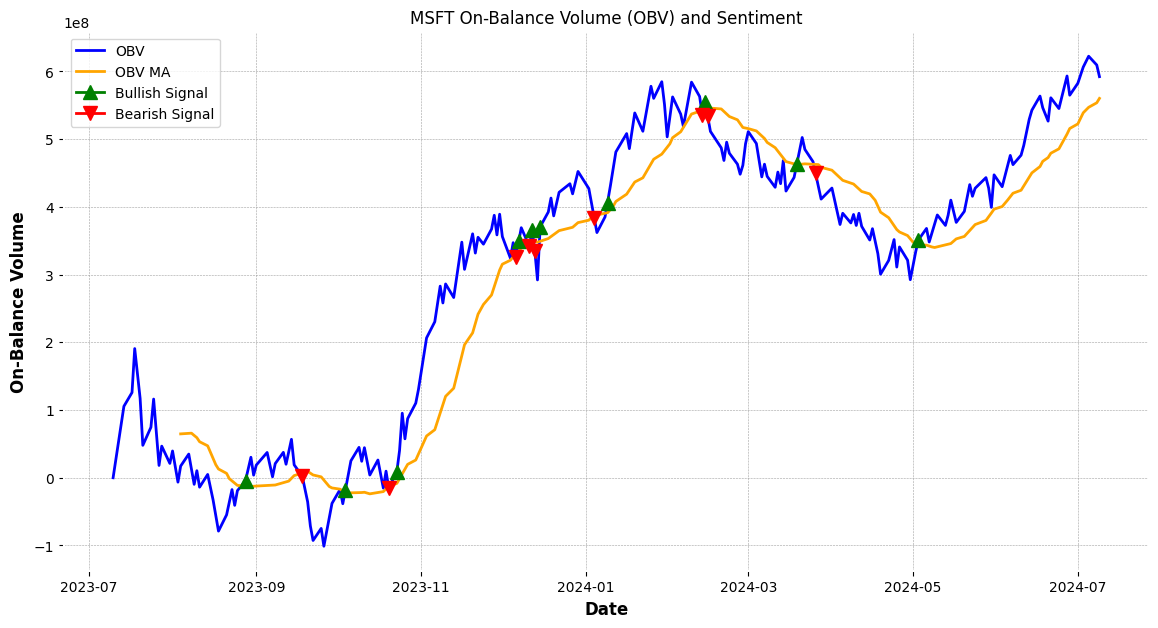

In [ ]:
# Function to fetch historical stock data
def fetch_historical_stock_data(ticker):
    stock = yf.Ticker(ticker)
    hist = stock.history(period="1y")
    return hist

# Function to calculate OBV
def calculate_obv(data):
    obv = [0]
    for i in range(1, len(data)):
        if data['Close'][i] > data['Close'][i - 1]:
            obv.append(obv[-1] + data['Volume'][i])
        elif data['Close'][i] < data['Close'][i - 1]:
            obv.append(obv[-1] - data['Volume'][i])
        else:
            obv.append(obv[-1])
    return obv

# Function to determine sentiment based on OBV and moving average crossover
def determine_sentiment(obv, obv_ma):
    bullish_signals = []
    bearish_signals = []

    for i in range(1, len(obv)):
        if obv[i] > obv_ma[i] and obv[i-1] <= obv_ma[i-1]:
            bullish_signals.append((i, obv[i]))
        elif obv[i] < obv_ma[i] and obv[i-1] >= obv_ma[i-1]:
            bearish_signals.append((i, obv[i]))

    return bullish_signals, bearish_signals

# Function to plot OBV with signals
def plot_obv(data, obv, obv_ma, bullish_signals, bearish_signals, ticker):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, obv, label='OBV', color='blue')
    plt.plot(data.index, obv_ma, label='OBV MA', color='orange')

    # Plot bullish signals
    for i, signal in enumerate(bullish_signals):
        label = 'Bullish Signal' if i == 0 else ""
        plt.plot(data.index[signal[0]], signal[1], marker='^', color='green', markersize=10, label=label)

    # Plot bearish signals
    for i, signal in enumerate(bearish_signals):
        label = 'Bearish Signal' if i == 0 else ""
        plt.plot(data.index[signal[0]], signal[1], marker='v', color='red', markersize=10, label=label)

    plt.xlabel('Date')
    plt.ylabel('On-Balance Volume')
    plt.title(f'{ticker} On-Balance Volume (OBV) and Sentiment')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
data = fetch_historical_stock_data(ticker)
data['OBV'] = calculate_obv(data)
data['OBV_MA'] = data['OBV'].rolling(window=20).mean()  # 20-day moving average of OBV
bullish_signals, bearish_signals = determine_sentiment(data['OBV'], data['OBV_MA'])
plot_obv(data, data['OBV'], data['OBV_MA'], bullish_signals, bearish_signals, ticker)



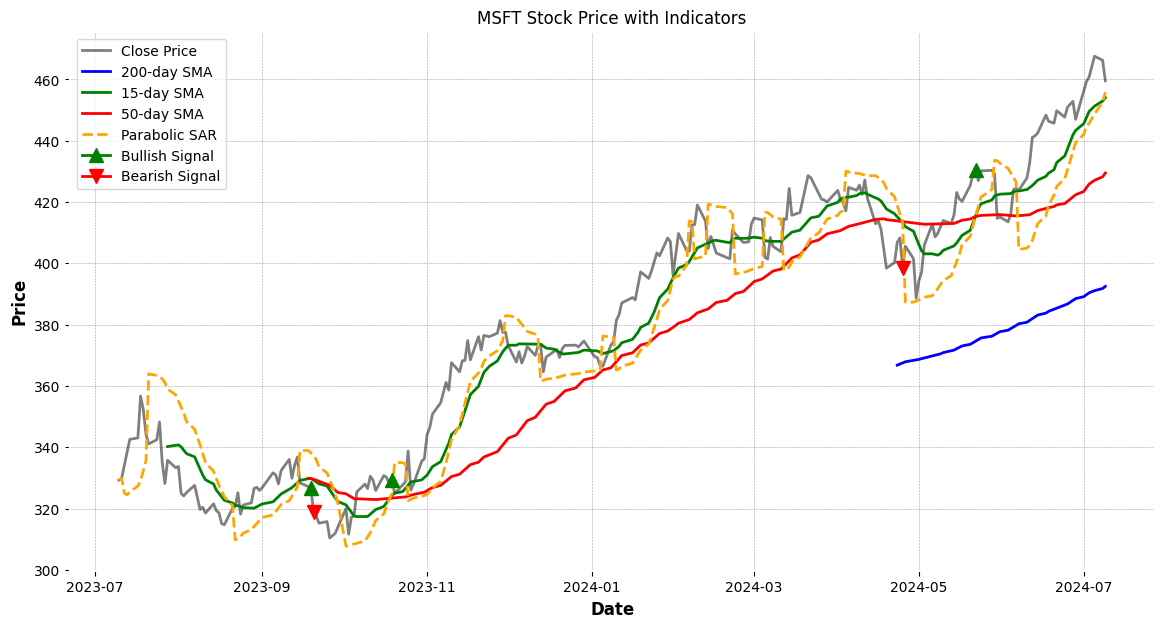

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import ta

# Function to fetch historical stock data
def fetch_historical_stock_data(ticker):
    stock = yf.Ticker(ticker)
    hist = stock.history(period="1y")
    return hist

# Function to calculate indicators
def calculate_indicators(data):
    data['200_SMA'] = data['Close'].rolling(window=200).mean()
    data['15_SMA'] = data['Close'].rolling(window=15).mean()
    data['50_SMA'] = data['Close'].rolling(window=50).mean()
    data['Parabolic_SAR'] = ta.trend.PSARIndicator(high=data['High'], low=data['Low'], close=data['Close']).psar()
    return data

# Function to determine signals
def determine_signals(data):
    bullish_signals = []
    bearish_signals = []

    for i in range(1, len(data)):
        # Bullish signal: 15-SMA crosses above 50-SMA
        if data['15_SMA'][i] > data['50_SMA'][i] and data['15_SMA'][i-1] <= data['50_SMA'][i-1]:
            bullish_signals.append((data.index[i], data['Close'][i]))
        # Bearish signal: 15-SMA crosses below 50-SMA
        elif data['15_SMA'][i] < data['50_SMA'][i] and data['15_SMA'][i-1] >= data['50_SMA'][i-1]:
            bearish_signals.append((data.index[i], data['Close'][i]))

    return bullish_signals, bearish_signals

# Function to plot indicators with signals
def plot_indicators(data, bullish_signals, bearish_signals, ticker):
    plt.figure(figsize=(14, 7))

    # Plot closing price
    plt.plot(data.index, data['Close'], label='Close Price', color='black', alpha=0.5)

    # Plot SMAs
    plt.plot(data.index, data['200_SMA'], label='200-day SMA', color='blue')
    plt.plot(data.index, data['15_SMA'], label='15-day SMA', color='green')
    plt.plot(data.index, data['50_SMA'], label='50-day SMA', color='red')

    # Plot Parabolic SAR
    plt.plot(data.index, data['Parabolic_SAR'], label='Parabolic SAR', color='orange', linestyle='--')

    # Plot bullish signals
    for i, signal in enumerate(bullish_signals):
        label = 'Bullish Signal' if i == 0 else ""
        plt.plot(signal[0], signal[1], marker='^', color='green', markersize=10, label=label)

    # Plot bearish signals
    for i, signal in enumerate(bearish_signals):
        label = 'Bearish Signal' if i == 0 else ""
        plt.plot(signal[0], signal[1], marker='v', color='red', markersize=10, label=label)

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{ticker} Stock Price with Indicators')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.grid(True)
    plt.show()

# Example usage
data = fetch_historical_stock_data(ticker)
data = calculate_indicators(data)
bullish_signals, bearish_signals = determine_signals(data)
plot_indicators(data, bullish_signals, bearish_signals, ticker)




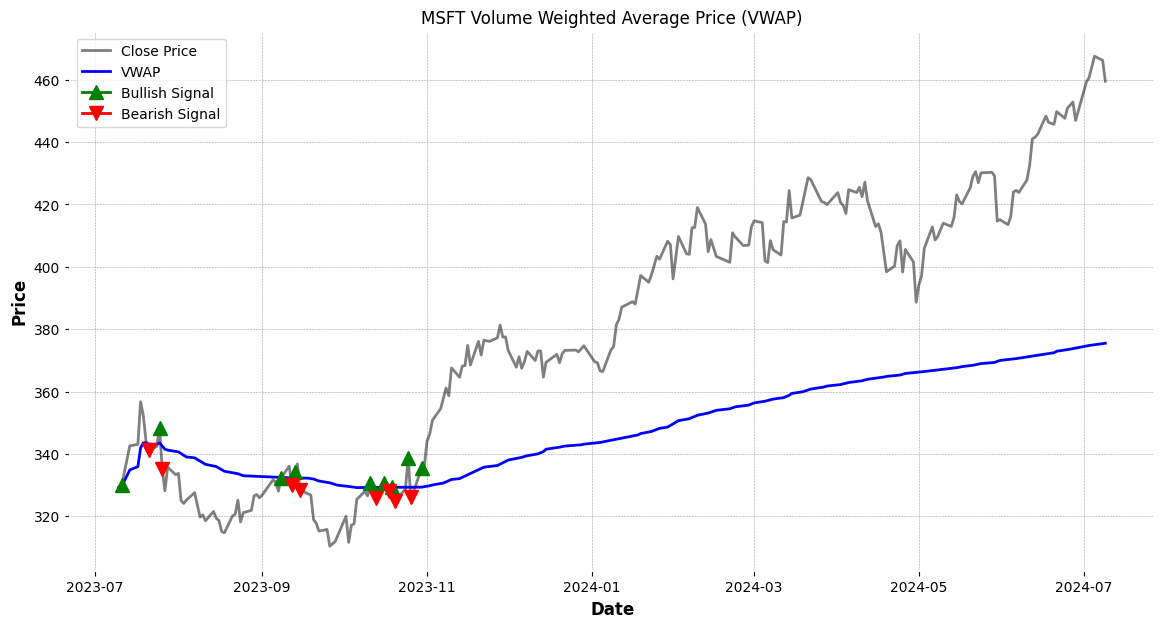

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Function to fetch historical stock data
def fetch_historical_stock_data(ticker):
    stock = yf.Ticker(ticker)
    hist = stock.history(period="1y")
    return hist

# Function to calculate VWAP
def calculate_vwap(data):
    data['Cumulative_TP_Volume'] = (data['Close'] * data['Volume']).cumsum()
    data['Cumulative_Volume'] = data['Volume'].cumsum()
    data['VWAP'] = data['Cumulative_TP_Volume'] / data['Cumulative_Volume']
    return data

# Function to determine signals
def determine_signals(data):
    bullish_signals = []
    bearish_signals = []

    for i in range(1, len(data)):
        # Bullish signal: Close price crosses above VWAP
        if data['Close'][i] > data['VWAP'][i] and data['Close'][i-1] <= data['VWAP'][i-1]:
            bullish_signals.append((data.index[i], data['Close'][i]))
        # Bearish signal: Close price crosses below VWAP
        elif data['Close'][i] < data['VWAP'][i] and data['Close'][i-1] >= data['VWAP'][i-1]:
            bearish_signals.append((data.index[i], data['Close'][i]))

    return bullish_signals, bearish_signals

# Function to plot VWAP with signals
def plot_vwap(data, bullish_signals, bearish_signals, ticker):
    plt.figure(figsize=(14, 7))

    # Plot closing price
    plt.plot(data.index, data['Close'], label='Close Price', color='black', alpha=0.5)

    # Plot VWAP
    plt.plot(data.index, data['VWAP'], label='VWAP', color='blue')

    # Plot bullish signals
    for signal in bullish_signals:
        plt.plot(signal[0], signal[1], marker='^', color='green', markersize=10, label='Bullish Signal' if signal == bullish_signals[0] else "")

    # Plot bearish signals
    for signal in bearish_signals:
        plt.plot(signal[0], signal[1], marker='v', color='red', markersize=10, label='Bearish Signal' if signal == bearish_signals[0] else "")

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{ticker} Volume Weighted Average Price (VWAP)')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.grid(True)
    plt.show()

# Example usage
data = fetch_historical_stock_data(ticker)
data = calculate_vwap(data)
bullish_signals, bearish_signals = determine_signals(data)
plot_vwap(data, bullish_signals, bearish_signals, ticker)



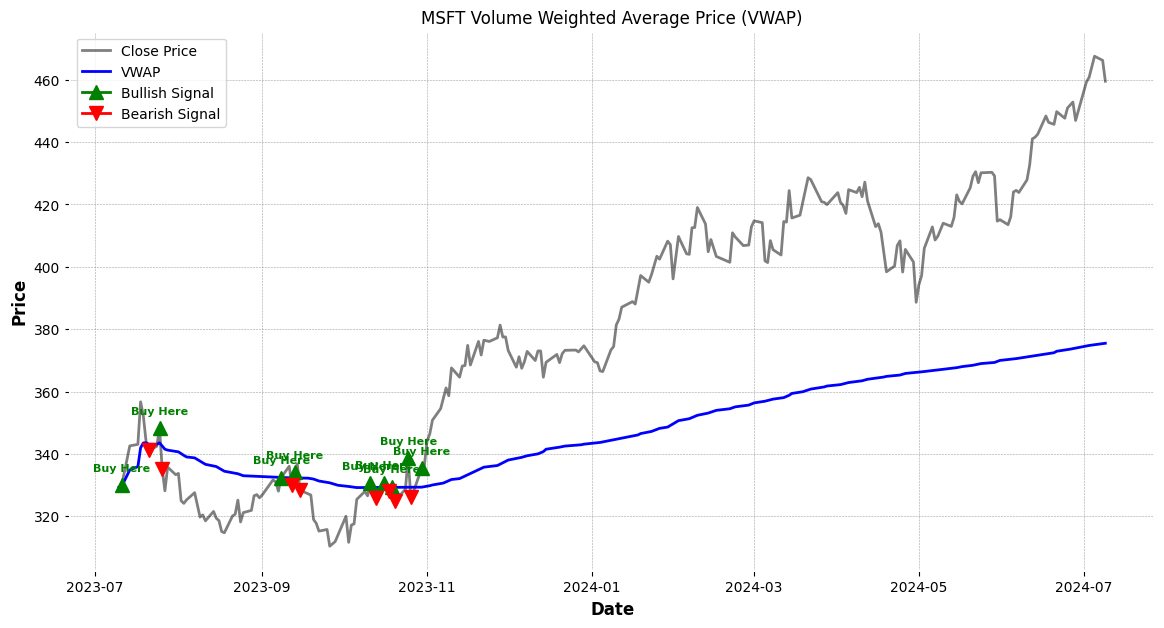

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Function to fetch historical stock data
def fetch_historical_stock_data(ticker):
    stock = yf.Ticker(ticker)
    hist = stock.history(period="1y")
    return hist

# Function to calculate VWAP
def calculate_vwap(data):
    data['Cumulative_TP_Volume'] = (data['Close'] * data['Volume']).cumsum()
    data['Cumulative_Volume'] = data['Volume'].cumsum()
    data['VWAP'] = data['Cumulative_TP_Volume'] / data['Cumulative_Volume']
    return data

# Function to determine signals
def determine_signals(data):
    bullish_signals = []
    bearish_signals = []

    for i in range(1, len(data)):
        # Bullish signal: Close price crosses above VWAP
        if data['Close'][i] > data['VWAP'][i] and data['Close'][i-1] <= data['VWAP'][i-1]:
            bullish_signals.append((data.index[i], data['Close'][i]))
        # Bearish signal: Close price crosses below VWAP
        elif data['Close'][i] < data['VWAP'][i] and data['Close'][i-1] >= data['VWAP'][i-1]:
            bearish_signals.append((data.index[i], data['Close'][i]))

    return bullish_signals, bearish_signals

# Function to plot VWAP with signals and support
def plot_vwap(data, bullish_signals, bearish_signals, ticker):
    plt.figure(figsize=(14, 7))

    # Plot closing price
    plt.plot(data.index, data['Close'], label='Close Price', color='black', alpha=0.5)

    # Plot VWAP
    plt.plot(data.index, data['VWAP'], label='VWAP', color='blue')

    # Plot bullish signals
    for signal in bullish_signals:
        plt.plot(signal[0], signal[1], marker='^', color='green', markersize=10, label='Bullish Signal' if signal == bullish_signals[0] else "")
        plt.annotate('Buy Here', (signal[0], signal[1]), textcoords="offset points", xytext=(0,10), ha='center', color='green', fontsize=8, weight='bold')

    # Plot bearish signals
    for signal in bearish_signals:
        plt.plot(signal[0], signal[1], marker='v', color='red', markersize=10, label='Bearish Signal' if signal == bearish_signals[0] else "")

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{ticker} Volume Weighted Average Price (VWAP)')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.grid(True)
    plt.show()

# Example usage
data = fetch_historical_stock_data(ticker)
data = calculate_vwap(data)
bullish_signals, bearish_signals = determine_signals(data)
plot_vwap(data, bullish_signals, bearish_signals, ticker)


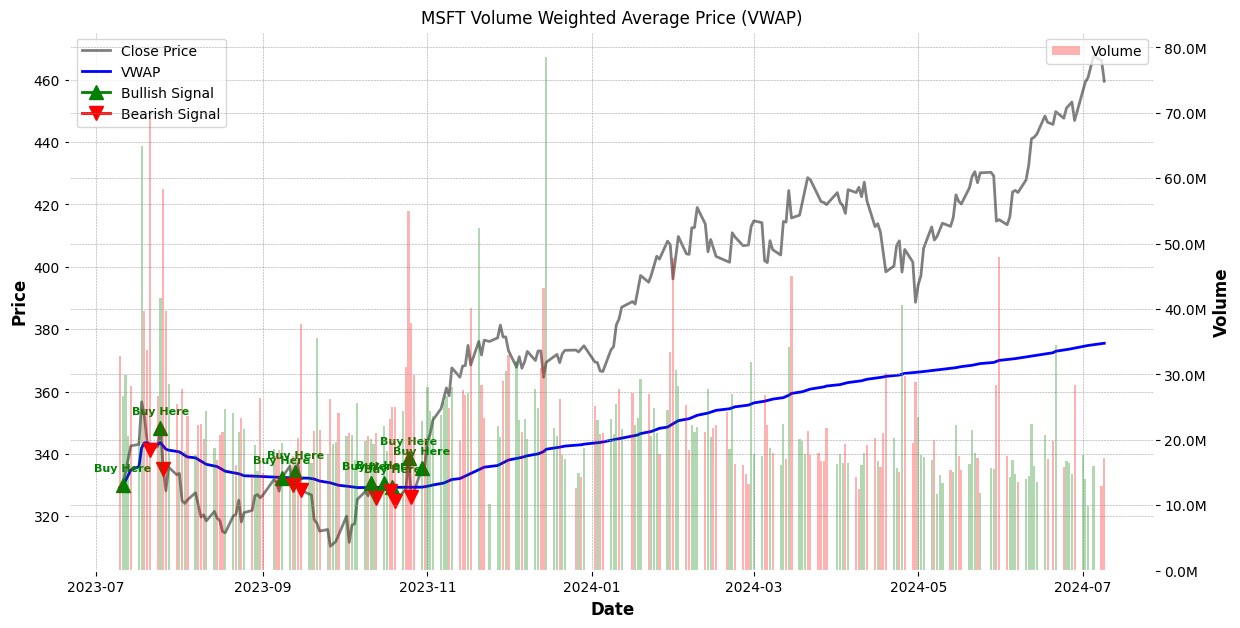

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Period:
# 1d: 1 day
# 5d: 5 days
# 1mo: 1 month
# 3mo: 3 months
# 6mo: 6 months
# 1y: 1 year
# 2y: 2 years
# 5y: 5 years
# 10y: 10 years
# ytd: Year to date
# max: Maximum period available for the stock

# Function to fetch historical stock data
def fetch_historical_stock_data(ticker):
    stock = yf.Ticker(ticker)
    hist = stock.history(period="1y")
    return hist

# Function to calculate VWAP
def calculate_vwap(data):
    data['Cumulative_TP_Volume'] = (data['Close'] * data['Volume']).cumsum()
    data['Cumulative_Volume'] = data['Volume'].cumsum()
    data['VWAP'] = data['Cumulative_TP_Volume'] / data['Cumulative_Volume']
    return data

# Function to determine signals
def determine_signals(data):
    bullish_signals = []
    bearish_signals = []

    for i in range(1, len(data)):
        # Bullish signal: Close price crosses above VWAP
        if data['Close'][i] > data['VWAP'][i] and data['Close'][i-1] <= data['VWAP'][i-1]:
            bullish_signals.append((data.index[i], data['Close'][i]))
        # Bearish signal: Close price crosses below VWAP
        elif data['Close'][i] < data['VWAP'][i] and data['Close'][i-1] >= data['VWAP'][i-1]:
            bearish_signals.append((data.index[i], data['Close'][i]))

    return bullish_signals, bearish_signals

# Function to format volume axis
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

# Function to plot VWAP with signals and support
def plot_vwap(data, bullish_signals, bearish_signals, ticker):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot closing price and VWAP on primary y-axis
    ax1.plot(data.index, data['Close'], label='Close Price', color='black', alpha=0.5)
    ax1.plot(data.index, data['VWAP'], label='VWAP', color='blue')

    # Plot bullish signals
    for signal in bullish_signals:
        ax1.plot(signal[0], signal[1], marker='^', color='green', markersize=10, label='Bullish Signal' if signal == bullish_signals[0] else "")
        ax1.annotate('Buy Here', (signal[0], signal[1]), textcoords="offset points", xytext=(0,10), ha='center', color='green', fontsize=8, weight='bold')

    # Plot bearish signals
    for signal in bearish_signals:
        ax1.plot(signal[0], signal[1], marker='v', color='red', markersize=10, label='Bearish Signal' if signal == bearish_signals[0] else "")

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.set_title(f'{ticker} Volume Weighted Average Price (VWAP)')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Create secondary y-axis for volume
    ax2 = ax1.twinx()
    colors = ['green' if data['Close'][i] > data['Open'][i] else 'red' for i in range(len(data))]
    ax2.bar(data.index, data['Volume'], color=colors, alpha=0.3, label='Volume')
    ax2.set_ylabel('Volume')
    ax2.yaxis.set_major_formatter(FuncFormatter(millions))
    ax2.legend(loc='upper right')

    plt.show()

# Example usage
# ticker = ""
data = fetch_historical_stock_data(ticker)
data = calculate_vwap(data)
bullish_signals, bearish_signals = determine_signals(data)
plot_vwap(data, bullish_signals, bearish_signals, ticker)




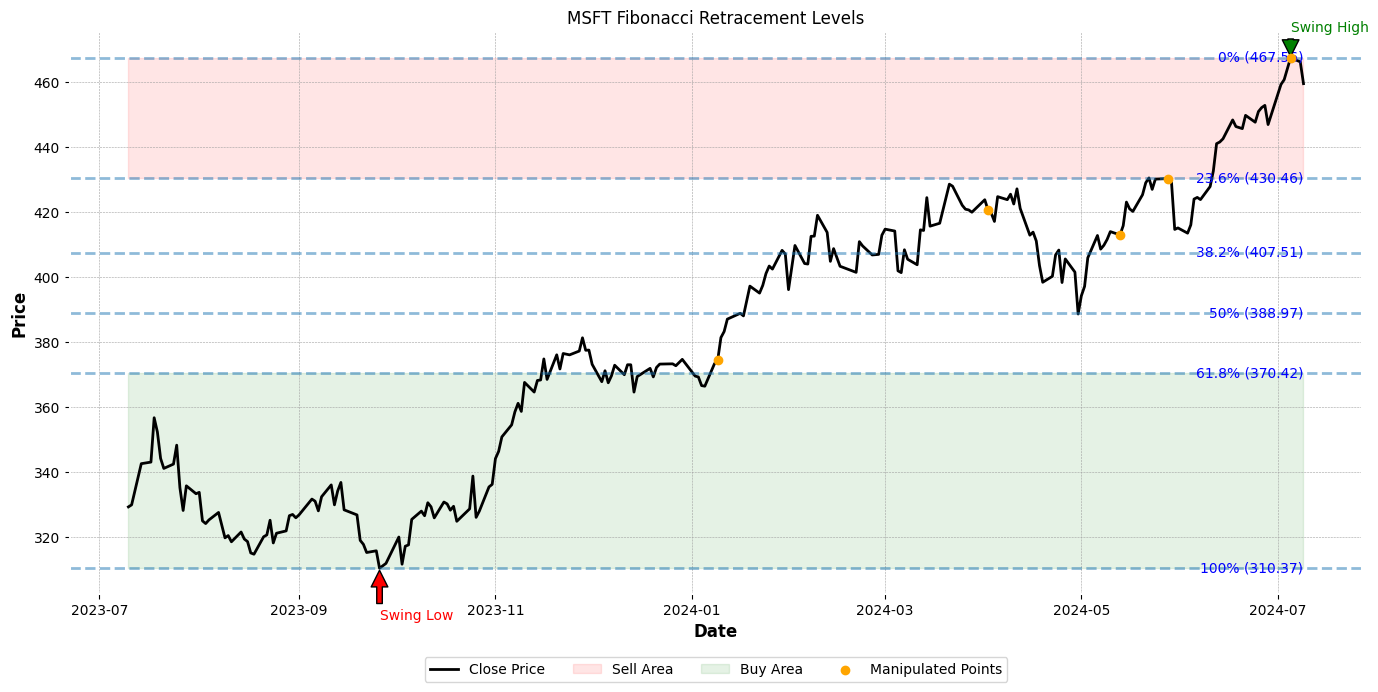

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Function to fetch historical stock data
def fetch_historical_stock_data(ticker):
    stock = yf.Ticker(ticker)
    hist = stock.history(period="1y")
    return hist

# Function to calculate Fibonacci retracement levels
def calculate_fibonacci_retracement_levels(data):
    max_price = data['Close'].max()
    min_price = data['Close'].min()
    diff = max_price - min_price
    levels = {
        '0%': max_price,
        '23.6%': max_price - 0.236 * diff,
        '38.2%': max_price - 0.382 * diff,
        '50%': max_price - 0.5 * diff,
        '61.8%': max_price - 0.618 * diff,
        '100%': min_price
    }
    return levels, max_price, min_price

# Function to plot Fibonacci retracement levels
def plot_fibonacci_retracement(data, levels, max_price, min_price, ticker):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['Close'], label='Close Price', color='black')

    for level, price in levels.items():
        plt.axhline(price, linestyle='--', alpha=0.5)
        plt.text(data.index[-1], price, f'{level} ({price:.2f})', ha='right', va='center', color='blue', fontsize=10)

    # Annotate swing high and swing low
    max_date = data['Close'].idxmax()
    min_date = data['Close'].idxmin()
    plt.annotate('Swing High', xy=(max_date, max_price), xytext=(max_date, max_price + (max_price - min_price) * 0.05),
                 arrowprops=dict(facecolor='green', shrink=0.05), fontsize=10, color='green')
    plt.annotate('Swing Low', xy=(min_date, min_price), xytext=(min_date, min_price - (max_price - min_price) * 0.1),
                 arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10, color='red')

    # Add shaded regions for Sell Area, Buy Area, and Manipulated Points
    plt.fill_between(data.index, levels['0%'], levels['23.6%'], color='red', alpha=0.1, label='Sell Area')
    plt.fill_between(data.index, levels['61.8%'], levels['100%'], color='green', alpha=0.1, label='Buy Area')

    # Mark manipulated points (for example purposes, marking random points)
    manipulated_points = data.sample(n=5)
    plt.scatter(manipulated_points.index, manipulated_points['Close'], color='orange', label='Manipulated Points', zorder=5)

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{ticker} Fibonacci Retracement Levels')
    plt.grid(True)

    # Move legend outside the plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
    plt.tight_layout()
    plt.show()

# Example usage
data = fetch_historical_stock_data(ticker)
levels, max_price, min_price = calculate_fibonacci_retracement_levels(data)
plot_fibonacci_retracement(data, levels, max_price, min_price, ticker)



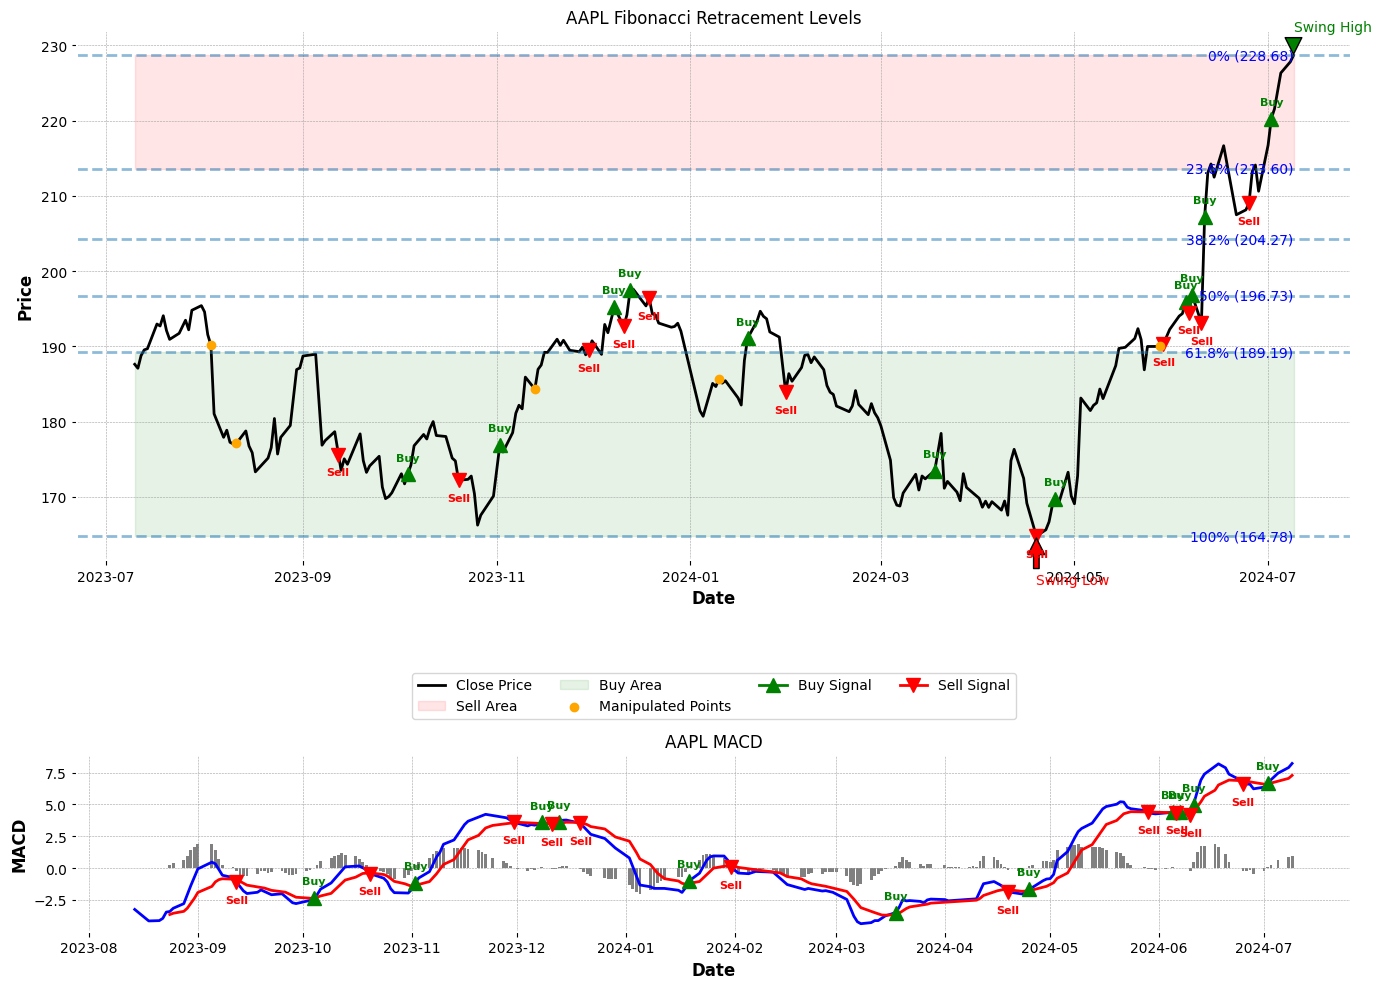

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import ta

# Function to fetch historical stock data
def fetch_historical_stock_data(ticker):
    stock = yf.Ticker(ticker)
    hist = stock.history(period="1y")
    return hist

# Function to calculate Fibonacci retracement levels
def calculate_fibonacci_retracement_levels(data):
    max_price = data['Close'].max()
    min_price = data['Close'].min()
    diff = max_price - min_price
    levels = {
        '0%': max_price,
        '23.6%': max_price - 0.236 * diff,
        '38.2%': max_price - 0.382 * diff,
        '50%': max_price - 0.5 * diff,
        '61.8%': max_price - 0.618 * diff,
        '100%': min_price
    }
    return levels, max_price, min_price

# Function to determine buy and sell signals based on MACD
def calculate_macd_signals(data):
    macd = ta.trend.MACD(data['Close'])
    data['MACD'] = macd.macd()
    data['MACD_Signal'] = macd.macd_signal()
    data['MACD_Hist'] = macd.macd_diff()

    buy_signals = []
    sell_signals = []

    for i in range(1, len(data)):
        if data['MACD'][i] > data['MACD_Signal'][i] and data['MACD'][i-1] <= data['MACD_Signal'][i-1]:
            buy_signals.append((data.index[i], data['MACD'][i]))
        elif data['MACD'][i] < data['MACD_Signal'][i] and data['MACD'][i-1] >= data['MACD_Signal'][i-1]:
            sell_signals.append((data.index[i], data['MACD'][i]))

    return buy_signals, sell_signals

# Function to plot Fibonacci retracement levels and MACD with signals
def plot_fibonacci_retracement_with_macd(data, levels, max_price, min_price, buy_signals, sell_signals, ticker):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]})

    # Plot the main price chart
    ax1.plot(data.index, data['Close'], label='Close Price', color='black')

    for level, price in levels.items():
        ax1.axhline(price, linestyle='--', alpha=0.5)
        ax1.text(data.index[-1], price, f'{level} ({price:.2f})', ha='right', va='center', color='blue', fontsize=10)

    # Annotate swing high and swing low
    max_date = data['Close'].idxmax()
    min_date = data['Close'].idxmin()
    ax1.annotate('Swing High', xy=(max_date, max_price), xytext=(max_date, max_price + (max_price - min_price) * 0.05),
                 arrowprops=dict(facecolor='green', shrink=0.05), fontsize=10, color='green')
    ax1.annotate('Swing Low', xy=(min_date, min_price), xytext=(min_date, min_price - (max_price - min_price) * 0.1),
                 arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10, color='red')

    # Add shaded regions for Sell Area and Buy Area
    ax1.fill_between(data.index, levels['0%'], levels['23.6%'], color='red', alpha=0.1, label='Sell Area')
    ax1.fill_between(data.index, levels['61.8%'], levels['100%'], color='green', alpha=0.1, label='Buy Area')

    # Mark manipulated points (for example purposes, marking random points)
    manipulated_points = data.sample(n=5)
    ax1.scatter(manipulated_points.index, manipulated_points['Close'], color='orange', label='Manipulated Points', zorder=5)

    # Plot buy and sell signals on price chart
    for signal in buy_signals:
        ax1.plot(signal[0], data.loc[signal[0], 'Close'], marker='^', color='green', markersize=10, label='Buy Signal' if signal == buy_signals[0] else "")
        ax1.annotate('Buy', (signal[0], data.loc[signal[0], 'Close']), textcoords="offset points", xytext=(0,10), ha='center', color='green', fontsize=8, weight='bold')
    for signal in sell_signals:
        ax1.plot(signal[0], data.loc[signal[0], 'Close'], marker='v', color='red', markersize=10, label='Sell Signal' if signal == sell_signals[0] else "")
        ax1.annotate('Sell', (signal[0], data.loc[signal[0], 'Close']), textcoords="offset points", xytext=(0,-15), ha='center', color='red', fontsize=8, weight='bold')

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.set_title(f'{ticker} Fibonacci Retracement Levels')
    ax1.grid(True)

    # Plot MACD
    ax2.plot(data.index, data['MACD'], label='MACD', color='blue')
    ax2.plot(data.index, data['MACD_Signal'], label='Signal Line', color='red')
    ax2.bar(data.index, data['MACD_Hist'], label='MACD Histogram', color='gray')

    # Plot buy and sell signals on MACD chart
    for signal in buy_signals:
        ax2.plot(signal[0], signal[1], marker='^', color='green', markersize=10, label='Buy Signal' if signal == buy_signals[0] else "")
        ax2.annotate('Buy', (signal[0], signal[1]), textcoords="offset points", xytext=(0,10), ha='center', color='green', fontsize=8, weight='bold')
    for signal in sell_signals:
        ax2.plot(signal[0], signal[1], marker='v', color='red', markersize=10, label='Sell Signal' if signal == sell_signals[0] else "")
        ax2.annotate('Sell', (signal[0], signal[1]), textcoords="offset points", xytext=(0,-15), ha='center', color='red', fontsize=8, weight='bold')

    ax2.set_xlabel('Date')
    ax2.set_ylabel('MACD')
    ax2.set_title(f'{ticker} MACD')
    ax2.grid(True)

    # Move legend outside the plot
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
    plt.tight_layout()
    plt.show()

# Example usage
ticker = "AAPL"
data = fetch_historical_stock_data(ticker)
levels, max_price, min_price = calculate_fibonacci_retracement_levels(data)
buy_signals, sell_signals = calculate_macd_signals(data)
plot_fibonacci_retracement_with_macd(data, levels, max_price, min_price, buy_signals, sell_signals, ticker)


# Prediction

Epoch 1/60
5/5 [==============================] - 5s 102ms/step - loss: 0.2045
Epoch 2/60
5/5 [==============================] - 0s 81ms/step - loss: 0.0466
Epoch 3/60
5/5 [==============================] - 0s 61ms/step - loss: 0.0283
Epoch 4/60
5/5 [==============================] - 0s 61ms/step - loss: 0.0089
Epoch 5/60
5/5 [==============================] - 0s 57ms/step - loss: 0.0145
Epoch 6/60
5/5 [==============================] - 1s 128ms/step - loss: 0.0087
Epoch 7/60
5/5 [==============================] - 1s 153ms/step - loss: 0.0083
Epoch 8/60
5/5 [==============================] - 1s 125ms/step - loss: 0.0070
Epoch 9/60
5/5 [==============================] - 1s 134ms/step - loss: 0.0065
Epoch 10/60
5/5 [==============================] - 1s 143ms/step - loss: 0.0078
Epoch 11/60
5/5 [==============================] - 1s 114ms/step - loss: 0.0061
Epoch 12/60
5/5 [==============================] - 0s 85ms/step - loss: 0.0059
Epoch 13/60
5/5 [==============================] - 0s 

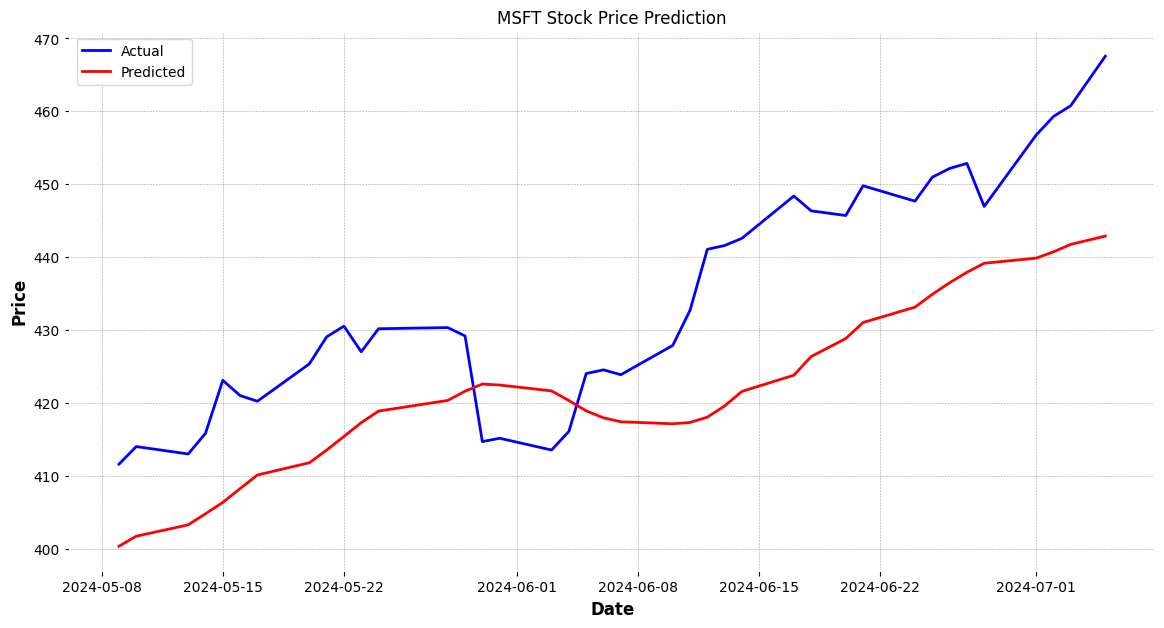

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_34 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_35 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_35 (Dropout)        (None, 50)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


# Function to fetch historical stock data
def fetch_historical_stock_data(ticker, period="1y"):
    stock = yf.Ticker(ticker)
    hist = stock.history(period=period)
    return hist

# Function to prepare data for LSTM
def prepare_data(data, window_size=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

    X = []
    y = []
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])

    X = np.array(X)
    y = np.array(y)

    return X, y, scaler

# Function to build and train the LSTM model
def build_and_train_lstm(X_train, y_train, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

    return model

# Function to make predictions
def make_predictions(model, data, window_size, scaler):
    scaled_data = scaler.transform(data['Close'].values.reshape(-1, 1))

    X_test = []
    for i in range(window_size, len(scaled_data)):
        X_test.append(scaled_data[i-window_size:i, 0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)

    return predictions

# Example usage
window_size = 60

# Fetch data
# ticker = '   '
data = fetch_historical_stock_data(ticker, period="1y")

# Prepare data
X, y, scaler = prepare_data(data, window_size)

# Split data into training and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build and train the LSTM model
model = build_and_train_lstm(X_train, y_train, epochs=60, batch_size=32)

# Make predictions
predictions = make_predictions(model, data, window_size, scaler)

# Adjust the length of y_test and predictions to match for plotting
y_test_plot = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test_plot):], y_test_plot, color='blue', label='Actual')
plt.plot(data.index[-len(y_test_plot):], predictions[-len(y_test_plot):], color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.legend()
plt.show()

# Print the model summary
model.summary()

Epoch 1/20
5/5 [==============================] - 16s 118ms/step - loss: 0.1659
Epoch 2/20
5/5 [==============================] - 1s 152ms/step - loss: 0.0215
Epoch 3/20
5/5 [==============================] - 1s 132ms/step - loss: 0.0237
Epoch 4/20
5/5 [==============================] - 1s 175ms/step - loss: 0.0111
Epoch 5/20
5/5 [==============================] - 1s 157ms/step - loss: 0.0116
Epoch 6/20
5/5 [==============================] - 1s 122ms/step - loss: 0.0071
Epoch 7/20
5/5 [==============================] - 1s 149ms/step - loss: 0.0082
Epoch 8/20
5/5 [==============================] - 1s 136ms/step - loss: 0.0075
Epoch 9/20
5/5 [==============================] - 1s 137ms/step - loss: 0.0062
Epoch 10/20
5/5 [==============================] - 1s 213ms/step - loss: 0.0076
Epoch 11/20
5/5 [==============================] - 1s 196ms/step - loss: 0.0062
Epoch 12/20
5/5 [==============================] - 1s 297ms/step - loss: 0.0050
Epoch 13/20
5/5 [==============================]

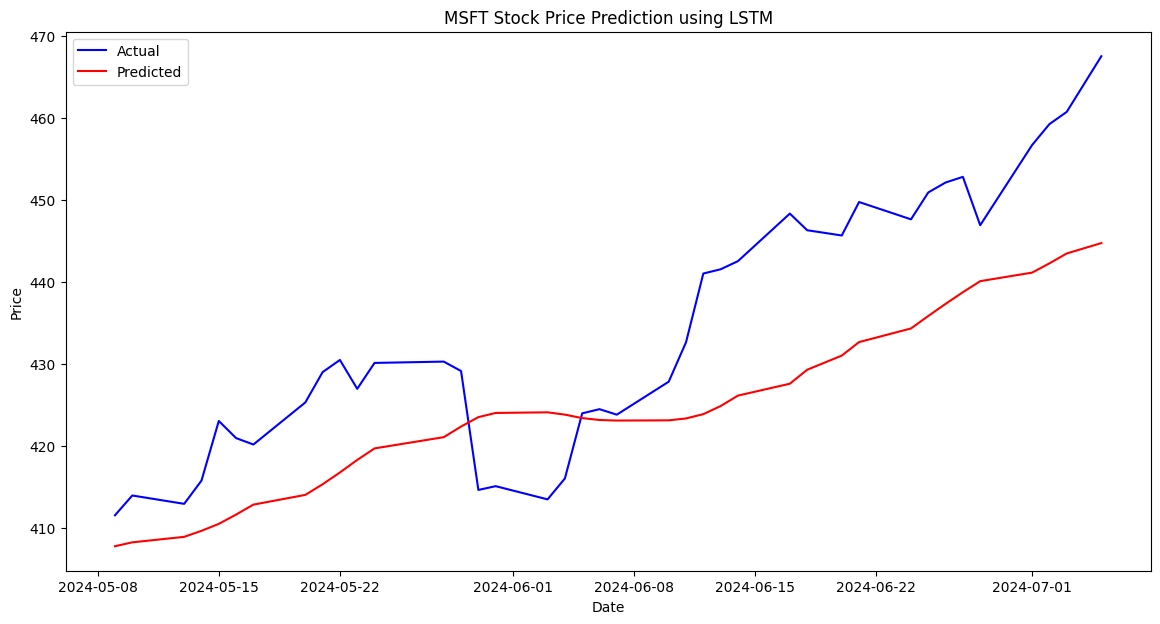

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Fetch historical stock data
stock = yf.Ticker(ticker)
data = stock.history(period="1y")

# Prepare the data
data['Date'] = data.index
data = data[['Date', 'Close']]
data.set_index('Date', inplace=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences
sequence_length = 60
X = []
y = []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])
X = np.array(X)
y = np.array(y)

# Split the data into training and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape the data for the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Actual')
plt.plot(data.index[-len(y_test):], predictions, color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{ticker} Stock Price Prediction using LSTM')
plt.legend()
plt.show()




In [ ]:
import pandas as pd
from textblob import TextBlob
import yfinance as yf
from datetime import datetime, timedelta
import requests
from bs4 import BeautifulSoup

def fetch_yahoo_news(ticker, days=10):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)
    url = f"https://finance.yahoo.com/quote/{ticker}/news?p={ticker}"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    articles = soup.find_all('li', class_='js-stream-content')
    news_articles = []
    for article in articles:
        date_str = article.find('time')['datetime']
        article_date = datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%S.%fZ")
        if article_date >= start_date:
            news_articles.append(article.find('a').text)
    return news_articles

def analyze_sentiment(news_articles):
    sentiments = []
    for article in news_articles:
        analysis = TextBlob(article)
        sentiment = analysis.sentiment.polarity
        sentiments.append(sentiment)
    return sentiments

# Example usage
ticker = 'MSFT'
news_articles = fetch_yahoo_news(ticker)
sentiments = analyze_sentiment(news_articles)
sentiment_score = sum(sentiments) / len(sentiments) if sentiments else 0

Epoch 1/50
3/3 [==============================] - 14s 148ms/step - loss: 0.1549
Epoch 2/50
3/3 [==============================] - 0s 135ms/step - loss: 0.0287
Epoch 3/50
3/3 [==============================] - 0s 151ms/step - loss: 0.0127
Epoch 4/50
3/3 [==============================] - 0s 146ms/step - loss: 0.0183
Epoch 5/50
3/3 [==============================] - 0s 141ms/step - loss: 0.0181
Epoch 6/50
3/3 [==============================] - 1s 161ms/step - loss: 0.0099
Epoch 7/50
3/3 [==============================] - 1s 268ms/step - loss: 0.0068
Epoch 8/50
3/3 [==============================] - 1s 257ms/step - loss: 0.0088
Epoch 9/50
3/3 [==============================] - 1s 279ms/step - loss: 0.0069
Epoch 10/50
3/3 [==============================] - 1s 280ms/step - loss: 0.0061
Epoch 11/50
3/3 [==============================] - 1s 252ms/step - loss: 0.0078
Epoch 12/50
3/3 [==============================] - 0s 144ms/step - loss: 0.0065
Epoch 13/50
3/3 [==============================]

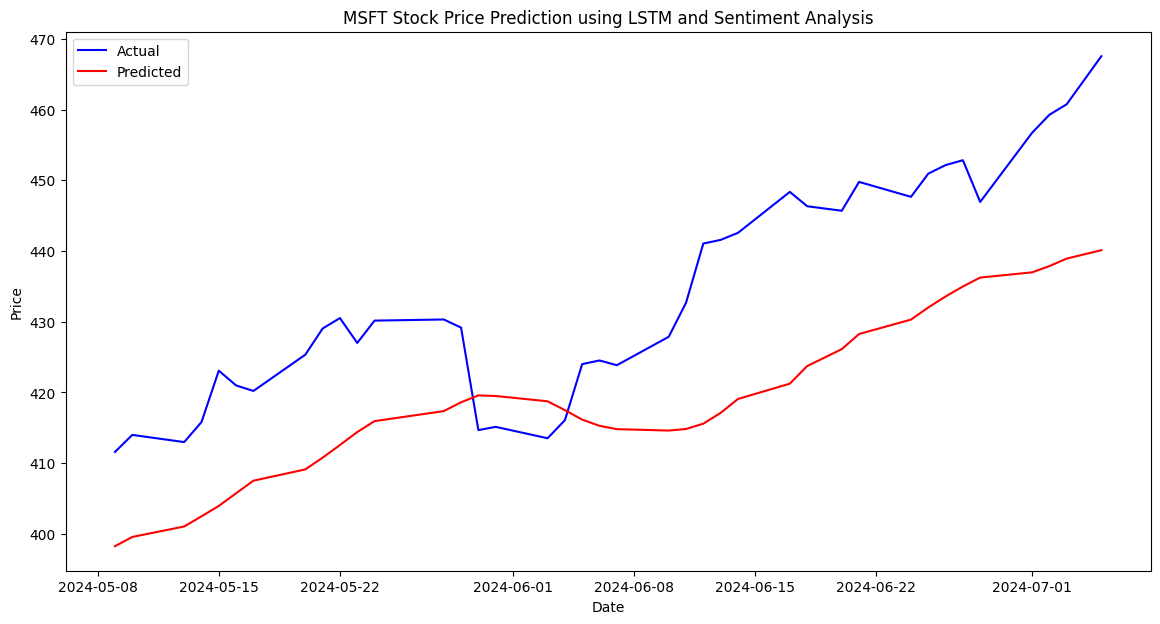

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from textblob import TextBlob
import requests
from bs4 import BeautifulSoup
import yfinance as yf
from datetime import datetime, timedelta

def fetch_yahoo_news(ticker, days=10):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)
    url = f"https://finance.yahoo.com/quote/{ticker}/news?p={ticker}"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    articles = soup.find_all('li', class_='js-stream-content')
    news_articles = []
    for article in articles:
        date_str = article.find('time')['datetime']
        article_date = datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%S.%fZ")
        if article_date >= start_date:
            news_articles.append(article.find('a').text)
    return news_articles

def analyze_sentiment(news_articles):
    sentiments = []
    for article in news_articles:
        analysis = TextBlob(article)
        sentiment = analysis.sentiment.polarity
        sentiments.append(sentiment)
    return sentiments

# Example usage
news_articles = fetch_yahoo_news(ticker)
sentiments = analyze_sentiment(news_articles)
sentiment_score = sum(sentiments) / len(sentiments) if sentiments else 0

# Fetch historical stock data
stock = yf.Ticker(ticker)
data = stock.history(period="1y")

# Prepare the data
data['Date'] = data.index
data = data[['Date', 'Close']]
data.set_index('Date', inplace=True)

# Add sentiment score as a feature
data['Sentiment'] = sentiment_score

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences
sequence_length = 60
X = []
y = []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i, 0])  # Close price
X = np.array(X)
y = np.array(y)

# Split the data into training and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape the data for the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Build the LSTM model with tuned hyperparameters
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with increased epochs and batch size
model.fit(X_train, y_train, epochs=50, batch_size=64)

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], 1))), axis=1))[:, 0]

# Inverse transform the actual values
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))), axis=1))[:, 0]

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], y_test_actual, color='blue', label='Actual')
plt.plot(data.index[-len(y_test):], predictions, color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{ticker} Stock Price Prediction using LSTM and Sentiment Analysis')
plt.legend()
plt.show()




Epoch 1/50
3/3 [==============================] - 5s 146ms/step - loss: 0.1615
Epoch 2/50
3/3 [==============================] - 1s 162ms/step - loss: 0.0250
Epoch 3/50
3/3 [==============================] - 0s 141ms/step - loss: 0.0152
Epoch 4/50
3/3 [==============================] - 0s 138ms/step - loss: 0.0153
Epoch 5/50
3/3 [==============================] - 0s 141ms/step - loss: 0.0178
Epoch 6/50
3/3 [==============================] - 1s 140ms/step - loss: 0.0083
Epoch 7/50
3/3 [==============================] - 0s 136ms/step - loss: 0.0077
Epoch 8/50
3/3 [==============================] - 0s 139ms/step - loss: 0.0110
Epoch 9/50
3/3 [==============================] - 0s 137ms/step - loss: 0.0054
Epoch 10/50
3/3 [==============================] - 0s 143ms/step - loss: 0.0068
Epoch 11/50
3/3 [==============================] - 1s 198ms/step - loss: 0.0080
Epoch 12/50
3/3 [==============================] - 1s 262ms/step - loss: 0.0057
Epoch 13/50
3/3 [==============================] 

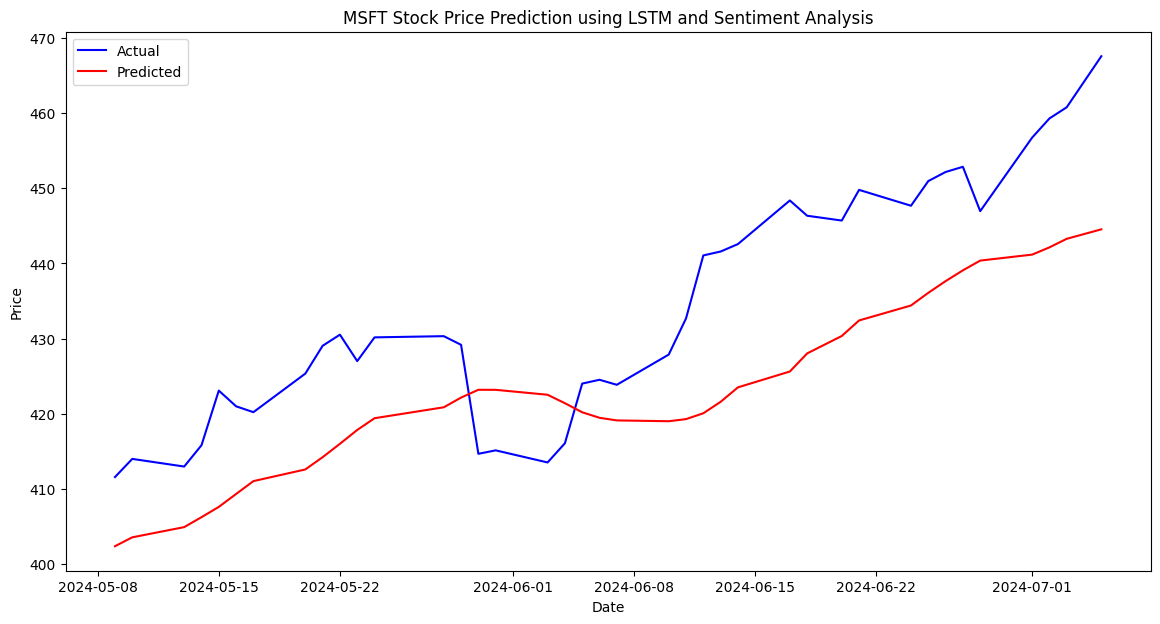

1/1 [==============================] - 0s 44ms/step


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 1

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from textblob import TextBlob
import requests
from bs4 import BeautifulSoup
import yfinance as yf
from datetime import datetime, timedelta

def fetch_yahoo_news(ticker, days=10):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)
    url = f"https://finance.yahoo.com/quote/{ticker}/news?p={ticker}"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    articles = soup.find_all('li', class_='js-stream-content')
    news_articles = []
    for article in articles:
        date_str = article.find('time')['datetime']
        article_date = datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%S.%fZ")
        if article_date >= start_date:
            news_articles.append(article.find('a').text)
    return news_articles

def analyze_sentiment(news_articles):
    sentiments = []
    for article in news_articles:
        analysis = TextBlob(article)
        sentiment = analysis.sentiment.polarity
        sentiments.append(sentiment)
    return sentiments

# Example usage
ticker = 'MSFT'
news_articles = fetch_yahoo_news(ticker)
sentiments = analyze_sentiment(news_articles)
sentiment_score = sum(sentiments) / len(sentiments) if sentiments else 0

# Fetch historical stock data
stock = yf.Ticker(ticker)
data = stock.history(period="1y")

# Prepare the data
data['Date'] = data.index
data = data[['Date', 'Close']]
data.set_index('Date', inplace=True)

# Add sentiment score as a feature
data['Sentiment'] = sentiment_score

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences
sequence_length = 60
X = []
y = []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i, 0])  # Close price
X = np.array(X)
y = np.array(y)

# Split the data into training and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape the data for the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Build the LSTM model with tuned hyperparameters
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with increased epochs and batch size
model.fit(X_train, y_train, epochs=50, batch_size=64)

# Make predictions for the test set
predictions = model.predict(X_test)

# Inverse transform the predictions
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

# Inverse transform the actual values
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], y_test_actual, color='blue', label='Actual')
plt.plot(data.index[-len(y_test):], predictions, color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{ticker} Stock Price Prediction using LSTM and Sentiment Analysis')
plt.legend()
plt.show()

# Predict the next week's stock prices
def predict_next_week(model, last_sequence, days=7):
    predictions = []
    current_sequence = last_sequence
    for _ in range(days):
        prediction = model.predict(np.expand_dims(current_sequence, axis=0))
        predictions.append(prediction[0, 0])
        current_sequence = np.append(current_sequence[1:], prediction, axis=0)
    return predictions

# Get the last sequence from the scaled data
last_sequence = scaled_data[-sequence_length:]

# Predict the next week's stock prices
next_week_predictions = predict_next_week(model, last_sequence)

# Inverse transform the predictions to get the actual values
next_week_predictions = scaler.inverse_transform(np.concatenate((np.array(next_week_predictions).reshape(-1, 1), np.zeros((len(next_week_predictions), scaled_data.shape[1] - 1))), axis=1))[:, 0]

# Print the next week's predicted stock prices
print("Next week's predicted stock prices:", next_week_predictions)

# Plot the next week's predicted stock prices
next_week_dates = [data.index[-1] + timedelta(days=i) for i in range(1, 8)]
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], y_test_actual, color='blue', label='Actual')
plt.plot(data.index[-len(y_test):], predictions, color='red', label='Predicted')
plt.plot(next_week_dates, next_week_predictions, color='green', label='Next Week Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{ticker} Stock Price Prediction and Next Week Forecast')
plt.legend()
plt.show()




In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Compute the MAE
mae = mean_absolute_error(y_test_actual, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Compute the MSE
mse = mean_squared_error(y_test_actual, predictions)
print(f'Mean Squared Error (MSE): {mse}')

# Compute the RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Compute the R-squared
r2 = r2_score(y_test_actual, predictions)
print(f'R-squared (R²): {r2}')

# Compute the MAPE
mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')


Mean Absolute Error (MAE): 12.536453824591238
Mean Squared Error (MSE): 182.47735264031462
Root Mean Squared Error (RMSE): 13.508417843711921
R-squared (R²): 0.2445511351154026
Mean Absolute Percentage Error (MAPE): 2.8636346353523816%


Epoch 1/50
5/5 [==============================] - 9s 101ms/step - loss: 0.1121
Epoch 2/50
5/5 [==============================] - 1s 104ms/step - loss: 0.0228
Epoch 3/50
5/5 [==============================] - 1s 151ms/step - loss: 0.0168
Epoch 4/50
5/5 [==============================] - 1s 169ms/step - loss: 0.0077
Epoch 5/50
5/5 [==============================] - 1s 299ms/step - loss: 0.0090
Epoch 6/50
5/5 [==============================] - 2s 388ms/step - loss: 0.0056
Epoch 7/50
5/5 [==============================] - 1s 109ms/step - loss: 0.0057
Epoch 8/50
5/5 [==============================] - 1s 109ms/step - loss: 0.0054
Epoch 9/50
5/5 [==============================] - 1s 101ms/step - loss: 0.0053
Epoch 10/50
5/5 [==============================] - 1s 110ms/step - loss: 0.0059
Epoch 11/50
5/5 [==============================] - 1s 101ms/step - loss: 0.0053
Epoch 12/50
5/5 [==============================] - 1s 106ms/step - loss: 0.0046
Epoch 13/50
5/5 [==============================] 

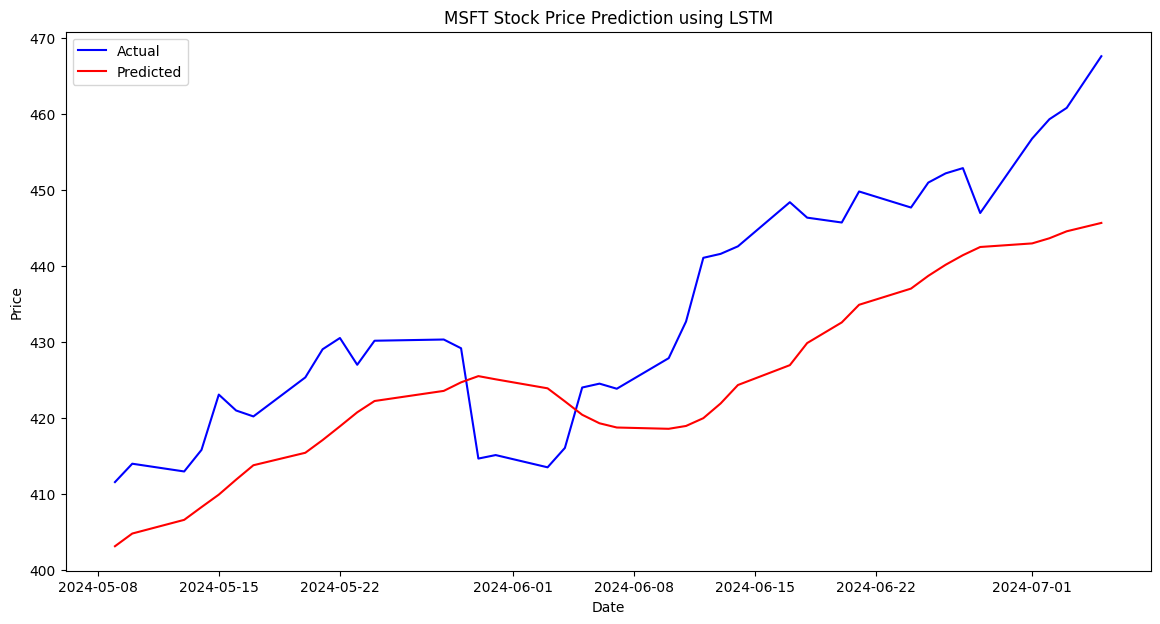

Mean Absolute Error (MAE): 11.193011944110575
Mean Squared Error (MSE): 149.23492891269802
Root Mean Squared Error (RMSE): 12.216174888757038
R-squared (R²): 0.38217342581435576
Mean Absolute Percentage Error (MAPE): 2.5575327776674825%


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Function to fetch historical stock data
def fetch_historical_stock_data(ticker):
    stock = yf.Ticker(ticker)
    hist = stock.history(period="1y")
    return hist

# Fetch and prepare the data
ticker = "MSFT"
data = fetch_historical_stock_data(ticker)
data = data[['Close']]
data['Date'] = data.index
data.set_index('Date', inplace=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences
sequence_length = 60
X = []
y = []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])
X = np.array(X)
y = np.array(y)

# Split the data into training and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape the data for the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model with adjusted hyperparameters
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.3))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Calculate actual values
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], y_test_actual, color='blue', label='Actual')
plt.plot(data.index[-len(y_test):], predictions, color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{ticker} Stock Price Prediction using LSTM')
plt.legend()
plt.show()

# Evaluate the model
mae = mean_absolute_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, predictions)
mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
